# Musformer

Mohnish Mirchandani 40301836


Although misleading, but the name seemed nice. The goal of this project is to try out multiple source separation models in speechbrain. The idea is to replicate building a model in the waveform domain directly. We see that multiple models try to solve the music source separation as a problem and most state-of-the-art models reach an SiSDR ratio of 9 to tackle the same. 

Most models working on this problem came into existence as a solution to the SDX (Sound Demixing) challenge. A few of the existing solutions are as follows: 
- **MMDenseLSTM**: Combines dense blocks with LSTMs for lightweight waveform separation.
- **Demucs (v1/v2)**: U-Net with bidirectional LSTMs; later versions add transformers.
- **ConvTasNet**: Efficient temporal convolutional network with learned encoder/decoder.
- **DPRNNet**: Dual-path RNN with attention, offering SOTA results at higher compute costs.
- **BandSplitRNN**: Separates audio into frequency bands processed by independent RNNs before recombination.
- **Wave-U-Net**: Adapts medical imaging's U-Net architecture for waveform-based source separation with learned down/upsampling.
- **Open-Unmix**: Spectrogram-based separation model using three-layer BiLSTMs with industry-standard implementation.
- **ResUNetDecouple**: U-Net variant with residual connections that decouples magnitude and phase processing.
- **TDCN++**: Improved temporal convolutional network with global skip connections and stacked dilation patterns.
- **Spleeter**: Facebook's lightweight CNN-based separator using spectrogram masking with pretrained models.

Our goal in this mini-project is to focus on the waveform domain. We try to implement four of these in their basest versions in order to learn how these architectures come into life for vocal separation from music. Along with that, we use multiple attempts to enhance our working. 

This is a project done by Mohnish Mirchandani, under professor Mirco Ravanelli, at Concordia University. Tagalong code for this can be found at: https://github.com/mirchandani-mohnish/Musformer



## Disclaimers
This notebook refers to the tip of the iceberg of multiple approaches tried along the way in order to reach here. It provides for a summary of the underlying work done around trials and errors in speech separation. Additionally, the informal nature of the text in this report is to keep the content somewhat light-hearted in order to ensure engagement with the reader...

The Github Repository is a good starting point for anyone who dares to explore the rest of the iceberg...

This report is intended to be self explanatory and so all the data you need to learn about these models should be referenced in the report itself. Additionally, all the models presented here have their intended recipes which you can use to cook your own models... 

Bonne Apetit!

## Step1 : Gaining Context (Literature Review)

### Gimme the Data!!
First things first, lets talk about the dataset and the models a bit. MUSDB18 is the benchmark dataset for music source separation, containing 150 full-track recordings (100 for training, 50 for test) with isolated stems for vocals, drums, bass, and other instruments. It provides professionally mixed 44.1kHz stereo audio, enabling evaluation of waveform-domain separation models. The dataset covers diverse genres and production styles, making it ideal for testing real-world generalization. It has become the standard benchmark for models like Open-Unmix, Demucs, and D3Net, with SI-SDR and SDR as primary metrics. The included Python toolbox (musdb) provides data loading, evaluation, and stem mixing utilities. Musdb is however dependent on something known as STEM files i.e. music tensor files combined and compressed into one. We use the kaggle uploaded version of the dataset which saves us the trouble of downloading, unzipping and uploading the same. You can find the dataset here: https://www.kaggle.com/datasets/jakerr5280/musdb18-music-source-separation-dataset


### The MusDB Package
One of the most helpful things available in the community to enhance the friendliness of this challenge is the [package provided by sigsep](https://github.com/sigsep/sigsep-mus-db/tree/master/musdb). Given that all the files are STEM format files i.e. a format extension which clubs multiple vectors into a cohesive mp4 format, the musdb package helps us read those using [FFMPEG](https://ffmpeg.org/). This allows us to load the vectors directly into the file without the need of creating a manifest file to read the particular values.



In [5]:
!pip install kagglehub

In [6]:
# 1.1 Get Our Dataset
import kagglehub
jakerr5280_musdb18_music_source_separation_dataset_path = kagglehub.dataset_download('jakerr5280/musdb18-music-source-separation-dataset')

print('Data source import complete.')


import os
db_path = '/notebooks/data'
output_path = '/notebooks/results'


# Create destination if needed
os.makedirs(db_path, exist_ok=True)


# Create destination if needed
os.makedirs(output_path, exist_ok=True)

Resuming download from 2589982720 bytes (1774773547 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/jakerr5280/musdb18-music-source-separation-dataset?dataset_version_number=1 (2589982720/4364756267) bytes left.


100%|██████████| 4.06G/4.06G [00:17<00:00, 99.2MB/s]

Extracting files...


Data source import complete.


In [7]:
db_path = '/notebooks/data'
output_path = '/notebooks/results'
result_file_path = '/notebooks/metrics.csv'



In [8]:
# 1.3 Move the result file into our directory
import os
import shutil

try:
    shutil.move(jakerr5280_musdb18_music_source_separation_dataset_path + '/train', db_path)
    shutil.move(jakerr5280_musdb18_music_source_separation_dataset_path + '/test', db_path)  # Moves the entire directory
    print(f"Moved {jakerr5280_musdb18_music_source_separation_dataset_path} to {db_path}")
except Exception as e:
    print(f"Error: {e}")


Moved /root/.cache/kagglehub/datasets/jakerr5280/musdb18-music-source-separation-dataset/versions/1 to /notebooks/data


In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(db_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/notebooks/data/train/James May - Dont Let Go.stem.mp4
/notebooks/data/train/North To Alaska - All The Same.stem.mp4
/notebooks/data/train/Titanium - Haunted Age.stem.mp4
/notebooks/data/train/Music Delta - Gospel.stem.mp4
/notebooks/data/train/Drumtracks - Ghost Bitch.stem.mp4
/notebooks/data/train/A Classic Education - NightOwl.stem.mp4
/notebooks/data/train/Leaf - Wicked.stem.mp4
/notebooks/data/train/Dreamers Of The Ghetto - Heavy Love.stem.mp4
/notebooks/data/train/Remember December - C U Next Time.stem.mp4
/notebooks/data/train/Port St Willow - Stay Even.stem.mp4
/notebooks/data/train/Patrick Talbot - A Reason To Leave.stem.mp4
/notebooks/data/train/Meaxic - You Listen.stem.mp4
/notebooks/data/train/Actions - South Of The Water.stem.mp4
/notebooks/data/train/Helado Negro - Mitad Del Mundo.stem.mp4
/notebooks/data/train/ANiMAL - Clinic A.stem.mp4
/notebooks/data/train/James May - All Souls Moon.stem.mp4
/notebooks/data/train/James May - On The Line.stem.mp4
/notebooks/data/train/J

## Step 2: Installing Stuff and Basic Setup

Ugghh... this is the boring part, but thats what makes the fun part funn! So we start by installing the necessary requirements for the entire project, as well as some global variables

The following are the use cases
- Musdb: Our python package wrapper which helps us iterate through the dataset
- mir_eval and museval: progressively used to check the sdri scores across models. These are the standard packages used in the MDX challenge as well.
- Speechbrain (Duhh... obviously)

Additionally, we set certain variables namely:
- db_path: The path to the dataset
- output_path: The working directory
- result_file_path: The file path for the metrics to be provided (Not really needed but thats where you see the magic)

We then create the `result_file` if needed and additionally setup the musdb object for global requirement

In [1]:
%%capture
!pip install musdb
!pip install mir_eval
!pip install museval

# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

# Clone SpeechBrain repository
!git clone https://github.com/speechbrain/speechbrain/

In [11]:
import os
import numpy as np
np.float_ = np.float64
import musdb

MUS_DB_PATH = db_path

mus = musdb.DB(root=MUS_DB_PATH)
mus_train = musdb.DB(root=MUS_DB_PATH,subsets="train", split="train")
mus_valid = musdb.DB(root=MUS_DB_PATH,subsets="train", split="valid")
mus_test = musdb.DB(root=MUS_DB_PATH,subsets="test")
print(mus_train[0])
print(mus_test[0])

A Classic Education - NightOwl
AM Contra - Heart Peripheral


In [2]:
db_path = '/notebooks/data'
output_path = '/notebooks/results'
result_file_path = '/notebooks/metrics.csv'



In [13]:
# Create the result file
import csv
from pathlib import Path

def create_metrics_csv(file_path):
    headers = [
        "model_name", "n_epochs", "learning_rate", "chunk_size", "sample_rate", "sdr", "sdr_i", "si-snr", "si-snr_i"
    ]
    
    Path(file_path).parent.mkdir(parents=True, exist_ok=True)

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)
    
    print(f"CSV file created successfully at: {file_path}")

if result_file_path is not None:
    create_metrics_csv(result_file_path)

CSV file created successfully at: /notebooks/metrics.csv


## Step 3: Make the Dataset Class

Since music tensors are difficult to load, we use a self made dataset class for our custom dataloader instead of using the DynamicDatasetItems provided by speechbrain. This allows us more flexibility with regard to selecting the tensors at runtime. Due to our prowess with STEM files, we can happily pick up stem chunks rather than taking the entire vocal array to pick up a chunk. 


This is what we do in the `load_stem_chunk` function. We also pick up some data about the music file in order to use later during the project. (We need a taste of what our recipe makes ;)

Musdb inherently gives us a train, valid and test split with 85, 13 and 44 songs respectively. We use the wrapper to decode stem files into their respective chunks and push it to the data pipeline. 
```
   # Load only the needed segment
    audio = source.audio[start:stop]
    
    # Convert and resample
    audio_tensor = torch.from_numpy(audio).float().permute(1, 0)
    return torchaudio.functional.resample(
        audio_tensor,
        orig_freq=track_info["rate"],
        new_freq=self.target_sr

```

Each music audio is resampled as per the requirement of that specific model run (in the hparams for that model). 


One thing to note is that while the input is stereo, one learns the hard way that when you have a source seperation for stereo input, you need to produce stereo output which means four separate channels at the very least. This is not particularly ideal for a small dataset and training instance. Thus we produce mono audio.


We return the following four objects as our dynamic items
```
{
    "mix_sig": load_stem_chunk("mix", random_chunk_start_val),
    "voc_sig": load_stem_chunk("vocals",random_chunk_start_val),
    "inst_sig": load_stem_chunk("accompaniment",random_chunk_start_val),
    "track_id": track_info["stem_id"]
}
```

Each correspond to their name types. The stem_id is the track name and stem id combined for saving results in the future. 


Each correspond to their name types. The stem_id is the track name and stem id combined for saving results in the future. 

One can note that the commented portions relate to different sections which one can tryout given relaxed constraints. The attempt was to load the entire tensor while chunking and resampling. Our (and most college level) constraint set does not allow us to go beyond 1,600,000 samples i.e. 20 seconds of audio with 8000 samples.

One of the models we train has a significant size (of the order of 200 million parameters) and as such it is recommeneded to train it on more data. Higher computational requirements are one way to go 

The **smart college student** way is to simply run across the dataset sectionally. We thus have a `random_chunk_start_val` which is a random digit which can be taken as a starting point for any data value. Across epochs - this allows us to train the model on psuedo new data



In [3]:
%%file dataset.py


import csv
import os
import sys

import torch
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import musdb
import numpy as np
import speechbrain as sb
import psutil


class MusDBDataset(Dataset):
    def __init__(self, root, subset="train", split=None, target_sr=8000, chunk_size=15):
        """
        True lazy-loading for MUSDB
        :param chunk_size: in seconds
        """
        if split is not None:
            self.db = musdb.DB(root=root, subsets=subset, split=split, is_wav=False)
        else:
            self.db = musdb.DB(root=root, subsets=subset, is_wav=False)
        self.target_sr = target_sr
        self.chunk_size = chunk_size
        self.tracks = [{
            "path": track.path,
            "duration": track.duration,
            "rate": track.rate,
            "stem_id": f"{track.name}_{track.stem_id}" # Needed for STEM access
        } for track in self.db.tracks]

    def __len__(self):
        return len(self.tracks)

    def __getitem__(self, idx):
        track_info = self.tracks[idx]
        
        # Load chunk directly from disk without full track loading
        def load_stem_chunk(stem_name, random_chunk_val=0):
            # MUSDB's internal lazy loading
            track = self.db.tracks[idx]
            if stem_name == "mix":
                source = track
            else:
                source = track.targets[stem_name]
            
            # Calculate chunk bounds
            start = random_chunk_val * track_info["rate"]
            stop = start + self.chunk_size * track_info["rate"]
            
            max_samples = source.audio.shape[0]  # Total samples in track
            
            # Ensure we don't go beyond track length
            if stop >= max_samples:
                start = max(0, max_samples - self.chunk_size * track_info["rate"])
                stop = max_samples
                
            # Load only the needed segment
            audio = source.audio[start:stop]
            
            # Convert and resample
            audio_tensor = torch.from_numpy(audio).float().permute(1, 0)
            return torchaudio.functional.resample(
                audio_tensor,
                orig_freq=track_info["rate"],
                new_freq=self.target_sr
            ).mean(dim=0, keepdim=False)
            
        
            # chunk_size = orig_sr * chunk_size_seconds  # Convert chunk size to samples
        
            # resampled_chunks = []
        
            # for i in range(0, audio_tensor.shape[1], chunk_size):
            #     chunk = audio_tensor[:, i:i + chunk_size]  # Extract chunk
            #     resampled_chunk = torchaudio.functional.resample(chunk, orig_freq=orig_sr, new_freq=target_sr)
            #     resampled_chunks.append(resampled_chunk)
        
            # # Concatenate back the processed chunks
            
            # resampled_audio = torch.cat(resampled_chunks, dim=1)
            
            # resampled_audio = resampled_audio.mean(dim=0, keepdim=False)
            
            # return resampled_audio
        # if random_chunk_start_val:
        
        random_chunk_start_val = 20 # seconds 
        
        return {
            "mix_sig": load_stem_chunk("mix", random_chunk_start_val),
            "voc_sig": load_stem_chunk("vocals",random_chunk_start_val),
            "inst_sig": load_stem_chunk("accompaniment",random_chunk_start_val),
            "track_id": track_info['stem_id']
        }

Overwriting dataset.py


## How We Doin...? (Methodology)

In order to learn and explore the different model approaches, we draw up each of the available models in speechbrain and try to retrofit them to a simple vocal separation task. The expectation being that the data more often than not, the model is able to reach state-of-the-art...ish levels. The steps we follow are as below:
1. Learn and draw up the model architecture using speechbrain modules wherever possible
2. Run them on a particular set of data values with particular hyperparameters
3. Compare the results

### Train.py
The `hparams` and `train.py` files both are heavily sourced from speechbrain recipes at : https://github.com/speechbrain/speechbrain/tree/develop/recipes

Speechbrain provides a framework to build ones model with a lot of functions. This provides modularity to our model development and as such a general description of our functions is as follows:

| Function                     | Description |
|------------------------------|-------------|
| `compute_forward()`          | Performs model forward pass for both training and inference |
| `compute_objectives()`       | Calculates loss between predictions and targets |
| `fit_batch()`                | Handles one training batch (forward pass + backpropagation) |
| `evaluate_batch()`           | Processes validation/test batches without gradient computation |
| `on_stage_end()`             | Performs end-of-epoch operations (logging, checkpointing, LR scheduling) |
| `save_results()`             | Computes and saves separation metrics (SDR, SI-SNR) |
| `save_audio()`               | Saves sample audio outputs for qualitative evaluation |


## Step 4: The Fun Part (Building the Models)

### ConvTasNet
- Key Idea: A fully convolutional, end-to-end waveform model that avoids spectrograms entirely.
- Encoder-Decoder: Uses 1D convolutions to learn a latent representation of the waveform.
- Temporal Convolutional Network (TCN): Processes the latent features with stacked dilated convolutions for long-range dependencies.
- Mask Estimation: Applies a soft mask in the latent space to separate sources.

Advantages:
- Lightweight and parallelizable (no RNNs).
- Strong performance on speech and music separation.



Personal Interests:
Convtasnet proves to be one of the smallest models which generally speaking outperforms most other state-of-the-art models (in the waveform domain). This is intruiging because it uses a simple encoder decoder architecture with a masknet type bottleneck. The version we use in this has 6.6 Million parameters and is successfully able to detach vocals from its accompaniements. It is lightweight and paralellizable and in our experiments it ends up giving a fair performance.

Reference and Sources:
- https://arxiv.org/abs/1809.07454
- https://pytorch.org/audio/main/generated/torchaudio.models.ConvTasNet.html
- https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.conv_tasnet.html
- https://github.com/JusperLee/Conv-TasNet
- https://github.com/speechbrain/speechbrain/blob/develop/recipes/WSJ0Mix/separation/hparams/convtasnet.yaml


#### Architecture
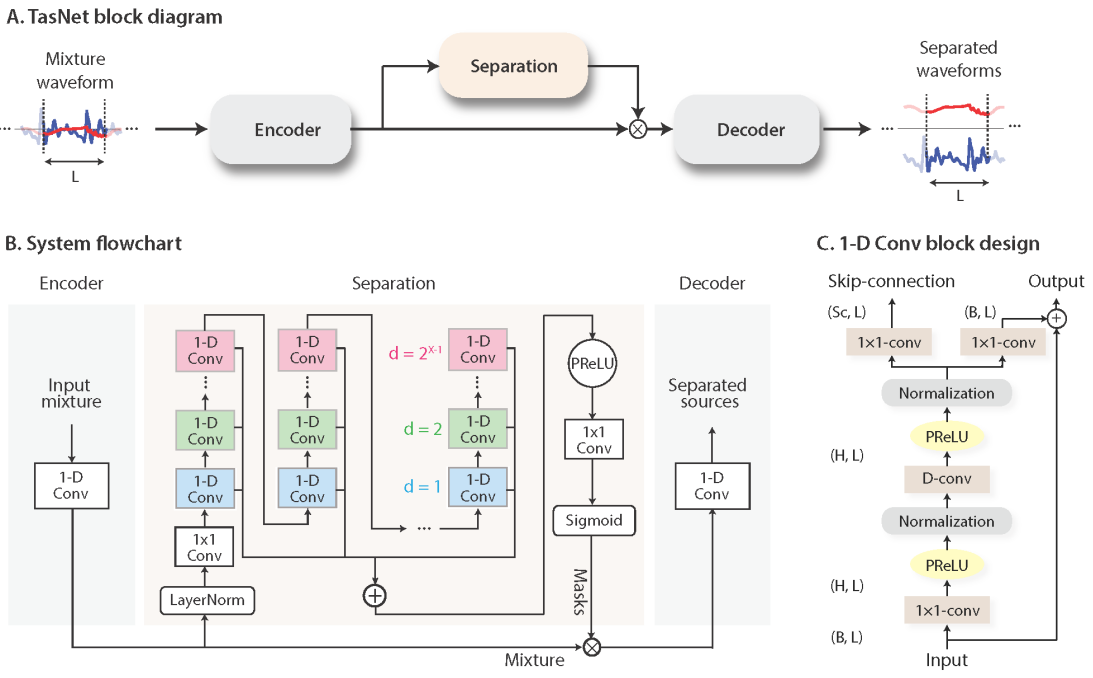

source: https://arxiv.org/abs/1809.07454

As can be seen above, we have an encoder, a masknet bottleneck and a decoder block. 

The **Encoder** is a simple one dimensional block with a kernel stride of 16. This produces the latent representations for the bottleneck

The **Bottleneck** is a Masknet module again taken from speechbrain. Here is the necessary jargon to understand our implementation

| Parameter  | Meaning                              | Typical Value      | Role                                                                 |
|------------|--------------------------------------|--------------------|----------------------------------------------------------------------|
| **`N`**    | Encoder/Decoder filters              | `256`              | Latent representation dimension.                                    |
| **`B`**    | Bottleneck channels (TCN)            | `256`              | Width of intermediate layers in TCN blocks.                         |
| **`H`**    | Hidden channels (TCN)                | `512`              | Channels in convolutional layers.                                   |
| **`P`**    | Kernel size (TCN)                    | `3`                | Temporal span of convolutions (e.g., `3x1`).                        |
| **`X`**    | Number of TCN stacks                 | `6`                | Repeat blocks for depth (e.g., 6 stacks).                           |
| **`R`**    | Repeats per stack (TCN)              | `4`                | Dilated convolutional layers per stack (e.g., 4 layers with dilation `1, 2, 4, 8`). |
| **`C`**    | Number of sources (output masks)     | `!ref <num_sources>` | Matches speakers to separate (e.g., `2` for 2-speaker separation).  |
| `norm_type`| Normalization type                   | `'gLN'` (Global LayerNorm) | Normalizes across time and channels.                          |
| `causal`   | Real-time processing                 | `True`             | No future context (set `False` for offline tasks).                  |
| `mask_nonlinear` | Mask activation                   | `'relu'`           | Ensures non-negative masks.                                         |

Finally, We have a dual path decoder which allows us to reconstruct the waveform from the latent representations. We have most of our values matching that of the encoder



In [3]:
%%file convtasnet-hparams.yaml
# ################################
# Model: ConvTasNet for Music Vocal Separation
# https://arxiv.org/abs/2010.13154
# Dataset : Musdb
# ################################
# Basic parameters
# Seed needs to be set at top of yaml, before objects with parameters are made

seed: 1234
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Data params
data_folder: !PLACEHOLDER


experiment_name: convtasnet
output_folder: !ref /notebooks/results/<experiment_name>/<seed>
train_log: !ref <output_folder>/train_log.txt
save_folder: !ref <output_folder>/save
train_data: !ref <output_folder>/train.json
valid_data: !ref <output_folder>/valid.json
test_data: !ref <output_folder>/test.json
skip_prep: False
db_path: '/notebooks/data'

result_file_path: !PLACEHOLDER


# Experiment params
precision: fp16 


noprogressbar: False
save_audio: True # Save estimated sources on disk
sample_rate: 8000
n_audio_to_save: 5
chunk_size: 20

####################### Training Parameters ####################################
N_epochs: 100
batch_size: 1
lr: 0.00015
clip_grad_norm: 5
loss_upper_lim: 999999  # this is the upper limit for an acceptable loss
num_sources: 2


# loss thresholding -- this thresholds the training loss
threshold_byloss: True
threshold: -30

# Encoder parameters
N_encoder_out: 256
# out_channels: 256
kernel_size: 16
kernel_stride: 8

# Dataloader options
dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: 1
    

####################### WaveDrop Params ########################################

use_wavedrop: True
# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 3  # Max number of audio chunks to drop
drop_chunk_length_low: 800  # Min length of audio chunks to drop
drop_chunk_length_high: 1600  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>


######################## Network Definition #######################
Encoder: !new:speechbrain.lobes.models.dual_path.Encoder
    kernel_size: !ref <kernel_size>
    out_channels: !ref <N_encoder_out>


MaskNet: !new:speechbrain.lobes.models.conv_tasnet.MaskNet
    N: 256
    B: 256
    H: 512
    P: 3
    X: 6
    R: 4
    C: !ref <num_sources>
    norm_type: 'gLN'
    causal: True
    mask_nonlinear: 'relu'


Decoder: !new:speechbrain.lobes.models.dual_path.Decoder
    in_channels: !ref <N_encoder_out>
    out_channels: 1
    kernel_size: !ref <kernel_size>
    stride: !ref <kernel_stride>
    bias: False

    
    
######################### Other Params ####################
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0

loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper

lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.5
    patience: 2
    dont_halve_until_epoch: 20

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <N_epochs>

modules:
    encoder: !ref <Encoder>
    decoder: !ref <Decoder>
    masknet: !ref <MaskNet>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <Encoder>
        decoder: !ref <Decoder>
        masknet: !ref <MaskNet>
        counter: !ref <epoch_counter>
        lr_scheduler: !ref <lr_scheduler>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

Overwriting convtasnet-hparams.yaml


In [15]:
%%file convtasnet-train.py
#!/usr/bin/env/python3
"""
Recipe for vocal separation using convtasnet
"""

import csv
import os
import sys

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm
import pdb

import musdb
import torchaudio
import numpy as np
from torch.utils.data import Dataset
import speechbrain as sb
import psutil
from dataset import MusDBDataset


import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.core import AMPConfig
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger
import time
from torch.utils.data import DataLoader

import musdb


# Define training procedure
class Separation(sb.Brain):
    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""

        # Unpack lists and put tensors in the right device
        mix, mix_lens = mix       
        mix, mix_lens = mix.to(self.device), mix_lens.to(self.device)      

        # Convert targets to tensor
        targets = torch.cat(
            [targets[i][0].unsqueeze(-1) for i in range(self.hparams.num_sources)],
            dim=-1,
        ).to(self.device)
        
        if stage == sb.Stage.TRAIN:
            with torch.no_grad():
                if self.hparams.use_wavedrop:
                    mix = self.hparams.drop_chunk(mix, mix_lens)
                    mix = self.hparams.drop_freq(mix)
        
        # Separation
        mix_w = self.hparams.Encoder(mix)
        est_mask = self.hparams.MaskNet(mix_w)
        mix_w = torch.stack([mix_w] * self.hparams.num_sources)
        sep_h = mix_w * est_mask
        
        # Decoding
        est_source = torch.cat(
            [
                self.hparams.Decoder(sep_h[i]).unsqueeze(-1)
                for i in range(self.hparams.num_sources)
            ],
            dim=-1,
        )

        # pad estimates as per requirement 
        T_origin = mix.size(1)
        T_est = est_source.size(1)
        if T_origin > T_est:
            est_source = F.pad(est_source, (0, 0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, :T_origin, :]

        return est_source, targets

    def compute_objectives(self, predictions, targets):
        """Computes the sinr loss"""
        return self.hparams.loss(targets, predictions)

    def fit_batch(self, batch):
        """Trains one batch"""
        
        
        amp = AMPConfig.from_name(self.precision)
        should_step = (self.step % self.grad_accumulation_factor) == 0
        # Unpacking batch list
        mixture = batch.mix_sig
        targets = [batch.voc_sig, batch.inst_sig] #mix_sig, voc_sig, inst_sig
       
        # training loop - compute forward and check loss
        predictions, targets = self.compute_forward(
            mixture, targets, sb.Stage.TRAIN
        )
        loss = self.compute_objectives(predictions, targets)

        # loss cropping
        if self.hparams.threshold_byloss:
            th = self.hparams.threshold
            loss = loss[loss > th]
            if loss.nelement() > 0:
                loss = loss.mean()
        else:
            loss = loss.mean()

        if (
            loss.nelement() > 0 and loss < self.hparams.loss_upper_lim
        ):  # the fix for computational problems
            loss.backward()
            if self.hparams.clip_grad_norm >= 0:
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(),
                    self.hparams.clip_grad_norm,
                )
            self.optimizer.step()
        else:
            self.nonfinite_count += 1
            logger.info(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    self.nonfinite_count
                )
            )
            loss.data = torch.tensor(0.0).to(self.device)
        self.optimizer.zero_grad()

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        snt_id = batch.track_id
        mixture = batch.mix_sig
        targets = [batch.voc_sig, batch.inst_sig]

        with torch.no_grad():
            predictions, targets = self.compute_forward(mixture, targets, stage)
            loss = self.compute_objectives(predictions, targets)

        # Manage audio file saving
        if stage == sb.Stage.TEST and self.hparams.save_audio:
            if hasattr(self.hparams, "n_audio_to_save"):
                if self.hparams.n_audio_to_save > 0:
                    self.save_audio(snt_id[0], mixture, targets, predictions)
                    self.hparams.n_audio_to_save += -1
            else:
                self.save_audio(snt_id[0], mixture, targets, predictions)

        return loss.mean().detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]}, min_keys=["si-snr"]
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )


    def save_results(self, test_loader):
        """This script computes the SDR and SI-SNR metrics and saves
        them into a csv file"""

        # This package is required for SDR computation
        from mir_eval.separation import bss_eval_sources

        # Create folders where to store audio
        save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

        # Variable init
        all_sdrs = []
        all_sdrs_i = []
        all_sisnrs = []
        all_sisnrs_i = []
        csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]


        def is_silent(source, threshold=1e-6):
            return np.max(np.abs(source[0])) < threshold or np.max(np.abs(source[1])) < threshold

        with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
            writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
            writer.writeheader()
            skip_cnt = 0

            # Loop over all test sentence
            with tqdm(test_loader, dynamic_ncols=True) as t:
                for i, batch in enumerate(t):
                    # Apply Separation
                    mixture, mix_len = batch.mix_sig
                    snt_id = batch.track_id
                    targets = [batch.voc_sig, batch.inst_sig]
                   

                    with torch.no_grad():
                        predictions, targets = self.compute_forward(
                            batch.mix_sig, targets, sb.Stage.TEST
                        )

                    # Compute SI-SNR
                    sisnr = self.compute_objectives(predictions, targets)

                    # Compute SI-SNR improvement
                    mixture_signal = torch.stack(
                        [mixture] * self.hparams.num_sources, dim=-1
                    )
                    mixture_signal = mixture_signal.to(targets.device)
                    sisnr_baseline = self.compute_objectives(
                        mixture_signal, targets
                    )
                    sisnr_i = sisnr - sisnr_baseline
                    
     
                    if not is_silent(targets[0].t().cpu().numpy()) and not is_silent(predictions[0].t().detach().cpu().numpy()) and not is_silent(mixture_signal[0].t().detach().cpu().numpy()):
                        
                    
                        sdr, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            predictions[0].t().detach().cpu().numpy(),
                            compute_permutation=False
                        )
    
                        sdr_baseline, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            mixture_signal[0].t().detach().cpu().numpy(),
                            compute_permutation=False
                        )
    
                        sdr_i = sdr.mean() - sdr_baseline.mean()
    
                        # Saving on a csv file
                        row = {
                            "snt_id": snt_id[0],
                            "sdr": sdr.mean(),
                            "sdr_i": sdr_i,
                            "si-snr": -sisnr.item(),
                            "si-snr_i": -sisnr_i.item(),
                        }
                        writer.writerow(row)
    
                        # Metric Accumulation
                        all_sdrs.append(sdr.mean())
                        all_sdrs_i.append(sdr_i.mean())
                        all_sisnrs.append(-sisnr.item())
                        all_sisnrs_i.append(-sisnr_i.item())
    
                
                    else:
                        skip_cnt += 1
                        print(f"Warning: skipping silent target, this has happened {skip_cnt} times")

                row = {
                    "snt_id": "avg",
                    "sdr": np.array(all_sdrs).mean(),
                    "sdr_i": np.array(all_sdrs_i).mean(),
                    "si-snr": np.array(all_sisnrs).mean(),
                    "si-snr_i": np.array(all_sisnrs_i).mean(),
                }
                writer.writerow(row)
                
        logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
        logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
        logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
        logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))
        if(self.hparams.result_file_path != ""):
            with open(self.hparams.result_file_path, "a", newline="", encoding="utf-8") as metrics_csv:
                writer = csv.DictWriter(metrics_csv, fieldnames=["model_name", "n_epochs", "learning_rate", "chunk_size", "sample_rate", "sdr", "sdr_i", "si-snr", "si-snr_i"])
                row = {
                        "model_name": self.hparams.experiment_name,
                        "learning_rate": self.hparams.lr,
                        "n_epochs": self.hparams.N_epochs,
                        "chunk_size":self.hparams.chunk_size,
                        "sample_rate":self.hparams.sample_rate,
                        "sdr": np.array(all_sdrs).mean(),
                        "sdr_i": np.array(all_sdrs_i).mean(),
                        "si-snr": np.array(all_sisnrs).mean(),
                        "si-snr_i": np.array(all_sisnrs_i).mean(),
                    }
                writer.writerow(row)

    def save_audio(self, snt_id, mixture, targets, predictions):
        "saves the test audio (mixture, targets, and estimated sources) on disk"

        # Create output folder
        save_path = os.path.join(self.hparams.save_folder, "audio_results")
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        for ns in range(self.hparams.num_sources):
            # Estimated source
            signal = predictions[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

            # Original source
            signal = targets[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

        # Mixture
        signal = mixture[0][0, :]
        signal = signal / signal.abs().max()
        save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
        torchaudio.save(
            save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
        )





if __name__ == "__main__":
    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Logger info
    logger = get_logger(__name__)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Update precision to bf16 if the device is CPU and precision is fp16
    if run_opts.get("device") == "cpu" and hparams.get("precision") == "fp16":
        hparams["precision"] = "bf16"

   

    # Brain class initialization
    separator = Separation(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )
 
    # Training
        
    # Usage with SpeechBrain
    train_data = MusDBDataset(hparams["db_path"], subset="train", split="train", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    valid_data = MusDBDataset(hparams["db_path"], subset="train", split="valid", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    test_data = MusDBDataset(hparams["db_path"], subset="test", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    

    # Create DataLoader
    train_loader = sb.dataio.dataloader.make_dataloader(
        train_data,
        batch_size=hparams["batch_size"],
        shuffle=True,
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )

    valid_loader = sb.dataio.dataloader.make_dataloader(
        valid_data,
        batch_size=hparams["batch_size"],
        shuffle=True,
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )

    test_loader = sb.dataio.dataloader.make_dataloader(
        test_data,
        batch_size=hparams["batch_size"],
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )
    
    separator.fit(
        separator.hparams.epoch_counter,
        train_loader,
        valid_loader,
        train_loader_kwargs=hparams["dataloader_opts"],
        valid_loader_kwargs=hparams["dataloader_opts"],
    )

    # # Eval
    separator.evaluate(test_loader, min_key="si-snr")
    separator.save_results(test_loader)

Overwriting convtasnet-train.py


In [4]:
!python3 convtasnet-train.py convtasnet-hparams.yaml --data_folder=db_path --result_file_path={result_file_path}

speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /notebooks/results/convtasnet/1234
speechbrain.core - Info: precision arg from hparam file is used
speechbrain.core - Info: noprogressbar arg from hparam file is used
speechbrain.core - Gradscaler enabled: `True`
speechbrain.core - Using training precision: `--precision=fp16`
speechbrain.core - Using evaluation precision: `--eval_precision=fp32`
speechbrain.core - Separation Model Statistics:
* Total Number of Trainable Parameters: 6.6M
* Total Number of Parameters: 6.6M
* Trainable Parameters represent 100.0000% of the total size.
speechbrain.utils.checkpoints - Loading a checkpoint from /notebooks/results/convtasnet/1234/save/CKPT+2025-04-23+16-23-02+00
speechbrain.utils.checkpoi

### Point of Interest :o:o

One interesting thing about this is while the other models tend to overfit pretty soon(written in archives) - This model does not particularly overfit and that is somewhat true with Demucs too which is a convolutional model. Not that that brings about a great benefit, but even across a run of hundred epochs, the only thing we see is a gradient plateuing. 

### Learn a bit :D:D

One key thing that you see in this as well as the other models is the use of wave-drop. During speech related training, wavedrop is a common practice utilized to generalize the model training better. You can see that in the segment as follows:

```
use_wavedrop: True
# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 3  # Max number of audio chunks to drop
drop_chunk_length_low: 800  # Min length of audio chunks to drop
drop_chunk_length_high: 1600  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

```

This essentially means we drop chunks and frequency values between our training data in order to ensure that the model does not simply rote-learn the input data

Due to smaller sample sizes, we drop chunks only between 800 and 1600 samples. 

Across all the four models, this brought about a change by about 20% pre and post training. 


## DPRNN (Dual-Path Recurrent Neural Network)
We now progress to the next bigger model. This is a good next stage because it uses Recurrent Neural Networks. 

**Key Idea**:
DPRNN is designed to model extremely long sequences efficiently by splitting input signals into smaller chunks and processing them through intra-chunk (local) and inter-chunk (global) RNNs. This dual-path approach addresses the limitations of traditional RNNs in handling long-term dependencies while maintaining low computational complexity.

**Architecture**
- Encoder: Converts input waveforms (or time-frequency representations) into latent features using 1D convolutions (time-domain).
- Decoder: Reconstructs separated signals using transposed convolutions or overlap-add operations.


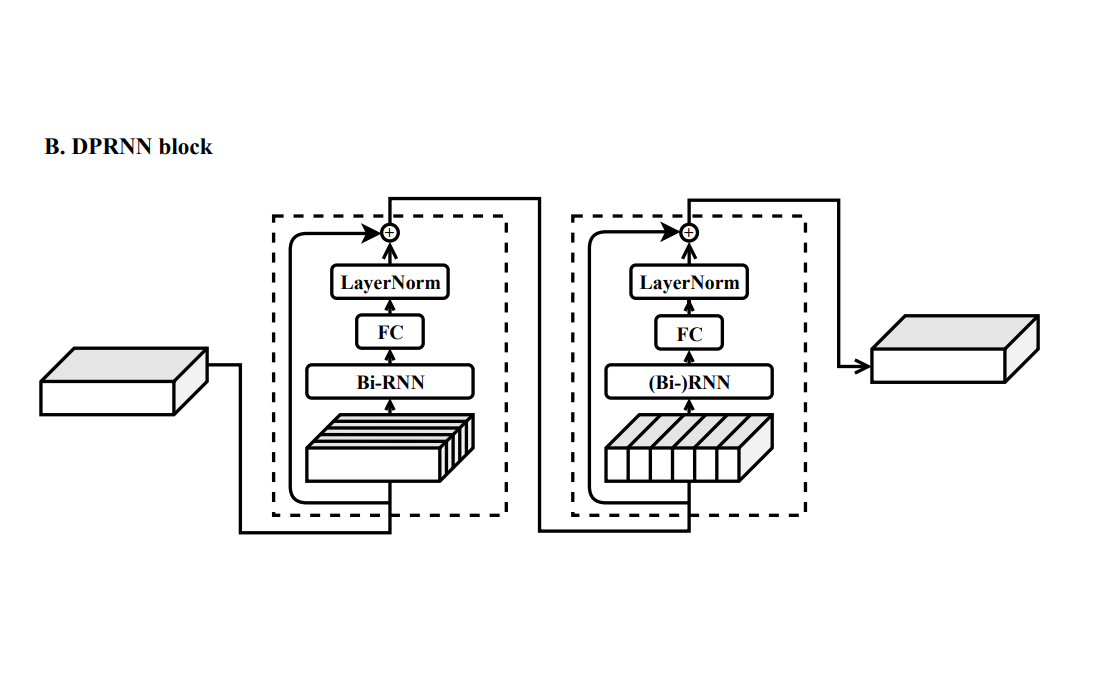
source: https://arxiv.org/pdf/1910.06379


**Dual-Path Processing**:
- Encoder and Decoder: Very Similar to ConvTasNet. Essentially a 1D encoder which converts our waveform input into latent representations for the model.
- Intra-chunk RNN: Models local patterns within short segments. It essentially splits input into segments and then outputs locally enhanced features.
- Inter-chunk RNN: Captures global dependencies across segments, enabling utterance-level modeling. 
- Mask Estimation: Learns soft masks in the latent space to separate sources, similar to ConvTasNet but with RNN-based temporal modeling.


**Personal Interests**
One interesting thing about this architecture is the fact that it is inspired by human learning. When humans read or listen to speach, we have a tendency to build context as we decipher short phenomes. i.e. each word or phenome is processed in its local as well as global context sequentially. This is what DPRNN aims to do. 
DPRNN has a Recurrent Nueral Network based architecture and thus has an innate ability to learn long term dependency related data too. However, it hs computationally taxing and one cannot train the model in parallel.

**References**
- https://github.com/speechbrain/speechbrain/blob/develop/recipes/WSJ0Mix/separation/hparams/dprnn.yaml
- https://github.com/speechbrain/speechbrain/blob/develop/recipes/WSJ0Mix/separation/train.py
- https://arxiv.org/pdf/1910.06379
- https://github.com/JusperLee/Dual-Path-RNN-Pytorch


In [16]:
%%file dprnn-hparams.yaml
# ################################
# Model: DPRNN for Music vocal separation
# https://arxiv.org/pdf/1910.06379
# Dataset : MusDB
# ################################
# Basic parameters
# Seed needs to be set at top of yaml, before objects with parameters are made


seed: 1234
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Data params

data_folder: !PLACEHOLDER
result_file_path: !PLACEHOLDER

experiment_name: dprnn
output_folder: !ref /notebooks/results/<experiment_name>/<seed>
train_log: !ref <output_folder>/train_log.txt
save_folder: !ref <output_folder>/save
train_data: !ref <output_folder>/train.json
valid_data: !ref <output_folder>/valid.json
test_data: !ref <output_folder>/test.json
skip_prep: False
db_path: '/notebooks/data'


# Experiment params
precision: fp16 # bf16, fp16 or fp32


noprogressbar: False
save_audio: True # Save estimated sources on disk
sample_rate: 8000
n_audio_to_save: 5
chunk_size: 20

####################### Training Parameters ####################################
N_epochs: 75
batch_size: 1
lr: 0.00015
clip_grad_norm: 5
loss_upper_lim: 999999  # this is the upper limit for an acceptable loss
num_sources: 2



# loss thresholding -- this thresholds the training loss
threshold_byloss: True
threshold: -30

# Encoder parameters
N_encoder_out: 256
out_channels: 256
kernel_size: 16
kernel_stride: 8

# Dataloader options
dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: 3



####################### WaveDrop Params ########################################

use_wavedrop: True
# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 3  # Max number of audio chunks to drop
drop_chunk_length_low: 800  # Min length of audio chunks to drop
drop_chunk_length_high: 1600  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

########################## Network Definition #######################
Encoder: !new:speechbrain.lobes.models.dual_path.Encoder
    kernel_size: !ref <kernel_size>
    out_channels: !ref <N_encoder_out>

intra: !new:speechbrain.lobes.models.dual_path.SBRNNBlock
    num_layers: 1
    input_size: !ref <out_channels>
    hidden_channels: !ref <out_channels>
    dropout: 0
    bidirectional: True

inter: !new:speechbrain.lobes.models.dual_path.SBRNNBlock
    num_layers: 1
    input_size: !ref <out_channels>
    hidden_channels: !ref <out_channels>
    dropout: 0
    bidirectional: True

MaskNet: !new:speechbrain.lobes.models.dual_path.Dual_Path_Model
    num_spks: !ref <num_sources>
    in_channels: !ref <N_encoder_out>
    out_channels: !ref <out_channels>
    num_layers: 6
    K: 250
    intra_model: !ref <intra>
    inter_model: !ref <inter>
    norm: ln
    linear_layer_after_inter_intra: True
    skip_around_intra: True

Decoder: !new:speechbrain.lobes.models.dual_path.Decoder
    in_channels: !ref <N_encoder_out>
    out_channels: 1
    kernel_size: !ref <kernel_size>
    stride: !ref <kernel_stride>
    bias: False

##################### Other Params #########################

optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0

loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper

lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.8
    patience: 2
    dont_halve_until_epoch: 75

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <N_epochs>

modules:
    encoder: !ref <Encoder>
    decoder: !ref <Decoder>
    masknet: !ref <MaskNet>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <Encoder>
        decoder: !ref <Decoder>
        masknet: !ref <MaskNet>
        counter: !ref <epoch_counter>
        lr_scheduler: !ref <lr_scheduler>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

Overwriting dprnn-hparams.yaml


In [18]:
%%file dprnn-train.py
#!/usr/bin/env/python3
"""
Recipe for vocal separation using convtasnet
"""

import csv
import os
import sys

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm
import pdb

import musdb
import torchaudio
import numpy as np
from torch.utils.data import Dataset
import speechbrain as sb
import psutil
from dataset import MusDBDataset


import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.core import AMPConfig
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger
import time
from torch.utils.data import DataLoader

import musdb


# Define training procedure
class Separation(sb.Brain):
    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""

        # Unpack lists and put tensors in the right device
        mix, mix_lens = mix       
        mix, mix_lens = mix.to(self.device), mix_lens.to(self.device)      

        # Convert targets to tensor
        targets = torch.cat(
            [targets[i][0].unsqueeze(-1) for i in range(self.hparams.num_sources)],
            dim=-1,
        ).to(self.device)
        
        if stage == sb.Stage.TRAIN:
            with torch.no_grad():
                if self.hparams.use_wavedrop:
                    mix = self.hparams.drop_chunk(mix, mix_lens)
                    mix = self.hparams.drop_freq(mix)
        
        # Separation
        mix_w = self.hparams.Encoder(mix)
        est_mask = self.hparams.MaskNet(mix_w)
        mix_w = torch.stack([mix_w] * self.hparams.num_sources)
        sep_h = mix_w * est_mask
        
        # Decoding
        est_source = torch.cat(
            [
                self.hparams.Decoder(sep_h[i]).unsqueeze(-1)
                for i in range(self.hparams.num_sources)
            ],
            dim=-1,
        )

        # pad estimates as per requirement 
        T_origin = mix.size(1)
        T_est = est_source.size(1)
        if T_origin > T_est:
            est_source = F.pad(est_source, (0, 0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, :T_origin, :]

        return est_source, targets

    def compute_objectives(self, predictions, targets):
        """Computes the sinr loss"""
        return self.hparams.loss(targets, predictions)

    def fit_batch(self, batch):
        """Trains one batch"""
        
        
        amp = AMPConfig.from_name(self.precision)
        should_step = (self.step % self.grad_accumulation_factor) == 0
        # Unpacking batch list
        mixture = batch.mix_sig
        targets = [batch.voc_sig, batch.inst_sig] #mix_sig, voc_sig, inst_sig
       
        
        predictions, targets = self.compute_forward(
            mixture, targets, sb.Stage.TRAIN
        )
        loss = self.compute_objectives(predictions, targets)

        if self.hparams.threshold_byloss:
            th = self.hparams.threshold
            loss = loss[loss > th]
            if loss.nelement() > 0:
                loss = loss.mean()
        else:
            loss = loss.mean()

        if (
            loss.nelement() > 0 and loss < self.hparams.loss_upper_lim
        ):  # the fix for computational problems
            loss.backward()
            if self.hparams.clip_grad_norm >= 0:
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(),
                    self.hparams.clip_grad_norm,
                )
            self.optimizer.step()
        else:
            self.nonfinite_count += 1
            logger.info(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    self.nonfinite_count
                )
            )
            loss.data = torch.tensor(0.0).to(self.device)
        self.optimizer.zero_grad()

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        snt_id = batch.track_id
        mixture = batch.mix_sig
        targets = [batch.voc_sig, batch.inst_sig]

        with torch.no_grad():
            predictions, targets = self.compute_forward(mixture, targets, stage)
            loss = self.compute_objectives(predictions, targets)

        # Manage audio file saving
        if stage == sb.Stage.TEST and self.hparams.save_audio:
            if hasattr(self.hparams, "n_audio_to_save"):
                if self.hparams.n_audio_to_save > 0:
                    self.save_audio(snt_id[0], mixture, targets, predictions)
                    self.hparams.n_audio_to_save += -1
            else:
                self.save_audio(snt_id[0], mixture, targets, predictions)

        return loss.mean().detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]}, min_keys=["si-snr"]
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )


    def save_results(self, test_loader):
        """This script computes the SDR and SI-SNR metrics and saves
        them into a csv file"""

        # This package is required for SDR computation
        from mir_eval.separation import bss_eval_sources

        # Create folders where to store audio
        save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

        # Variable init
        all_sdrs = []
        all_sdrs_i = []
        all_sisnrs = []
        all_sisnrs_i = []
        csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]


        def is_silent(source, threshold=1e-6):
            return np.max(np.abs(source[0])) < threshold or np.max(np.abs(source[1])) < threshold

        with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
            writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
            writer.writeheader()
            skip_cnt = 0

            # Loop over all test sentence
            with tqdm(test_loader, dynamic_ncols=True) as t:
                for i, batch in enumerate(t):
                    # Apply Separation
                    mixture, mix_len = batch.mix_sig
                    snt_id = batch.track_id
                    targets = [batch.voc_sig, batch.inst_sig]
                   

                    with torch.no_grad():
                        predictions, targets = self.compute_forward(
                            batch.mix_sig, targets, sb.Stage.TEST
                        )

                    # Compute SI-SNR
                    sisnr = self.compute_objectives(predictions, targets)

                    # Compute SI-SNR improvement
                    mixture_signal = torch.stack(
                        [mixture] * self.hparams.num_sources, dim=-1
                    )
                    mixture_signal = mixture_signal.to(targets.device)
                    sisnr_baseline = self.compute_objectives(
                        mixture_signal, targets
                    )
                    sisnr_i = sisnr - sisnr_baseline
                    
     
                    if not is_silent(targets[0].t().cpu().numpy()) and not is_silent(predictions[0].t().detach().cpu().numpy()) and not is_silent(mixture_signal[0].t().detach().cpu().numpy()):
                        
                    
                        sdr, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            predictions[0].t().detach().cpu().numpy(),
                            compute_permutation=False
                        )
    
                        sdr_baseline, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            mixture_signal[0].t().detach().cpu().numpy(),
                            compute_permutation=False
                        )
    
                        sdr_i = sdr.mean() - sdr_baseline.mean()
    
                        # Saving on a csv file
                        row = {
                            "snt_id": snt_id[0],
                            "sdr": sdr.mean(),
                            "sdr_i": sdr_i,
                            "si-snr": -sisnr.item(),
                            "si-snr_i": -sisnr_i.item(),
                        }
                        writer.writerow(row)
    
                        # Metric Accumulation
                        all_sdrs.append(sdr.mean())
                        all_sdrs_i.append(sdr_i.mean())
                        all_sisnrs.append(-sisnr.item())
                        all_sisnrs_i.append(-sisnr_i.item())
                    else:
                        skip_cnt += 1
                        print(f"Warning: skipping silent target, this has happened {skip_cnt} times")
            row = {
                "snt_id": "avg",
                "sdr": np.array(all_sdrs).mean(),
                "sdr_i": np.array(all_sdrs_i).mean(),
                "si-snr": np.array(all_sisnrs).mean(),
                "si-snr_i": np.array(all_sisnrs_i).mean(),
            }
            writer.writerow(row)

        logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
        logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
        logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
        logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))
        if(self.hparams.result_file_path != ""):
            with open(self.hparams.result_file_path, "a", newline="", encoding="utf-8") as metrics_csv:
                writer = csv.DictWriter(metrics_csv, fieldnames=["model_name", "n_epochs", "learning_rate", "chunk_size", "sample_rate", "sdr", "sdr_i", "si-snr", "si-snr_i"])
                row = {
                        "model_name": self.hparams.experiment_name,
                        "learning_rate": self.hparams.lr,
                        "n_epochs": self.hparams.N_epochs,
                        "chunk_size":self.hparams.chunk_size,
                        "sample_rate":self.hparams.sample_rate,
                        "sdr": np.array(all_sdrs).mean(),
                        "sdr_i": np.array(all_sdrs_i).mean(),
                        "si-snr": np.array(all_sisnrs).mean(),
                        "si-snr_i": np.array(all_sisnrs_i).mean(),
                    }
                writer.writerow(row)

    def save_audio(self, snt_id, mixture, targets, predictions):
        "saves the test audio (mixture, targets, and estimated sources) on disk"

        # Create output folder
        save_path = os.path.join(self.hparams.save_folder, "audio_results")
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        for ns in range(self.hparams.num_sources):
            # Estimated source
            signal = predictions[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

            # Original source
            signal = targets[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

        # Mixture
        signal = mixture[0][0, :]
        signal = signal / signal.abs().max()
        save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
        torchaudio.save(
            save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
        )





if __name__ == "__main__":
    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Logger info
    logger = get_logger(__name__)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Update precision to bf16 if the device is CPU and precision is fp16
    if run_opts.get("device") == "cpu" and hparams.get("precision") == "fp16":
        hparams["precision"] = "bf16"

   

    # Brain class initialization
    separator = Separation(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )
 
    # Training
        
    # Usage with SpeechBrain
    train_data = MusDBDataset(hparams["db_path"], subset="train", split="train", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    valid_data = MusDBDataset(hparams["db_path"], subset="train", split="valid", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    test_data = MusDBDataset(hparams["db_path"], subset="test", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    

    # Create DataLoader
    train_loader = sb.dataio.dataloader.make_dataloader(
        train_data,
        batch_size=hparams["batch_size"],
        shuffle=True,
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )

    valid_loader = sb.dataio.dataloader.make_dataloader(
        valid_data,
        batch_size=hparams["batch_size"],
        shuffle=True,
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )

    test_loader = sb.dataio.dataloader.make_dataloader(
        test_data,
        batch_size=hparams["batch_size"],
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )
    
    separator.fit(
        separator.hparams.epoch_counter,
        train_loader,
        valid_loader,
        train_loader_kwargs=hparams["dataloader_opts"],
        valid_loader_kwargs=hparams["dataloader_opts"],
    )

    # # Eval
    separator.evaluate(test_loader, min_key="si-snr")
    separator.save_results(test_loader)

Overwriting dprnn-train.py


In [8]:
!python3 dprnn-train.py dprnn-hparams.yaml --data_folder=db_path --result_file_path={result_file_path}

speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /notebooks/results/dprnn/1234
speechbrain.core - Info: precision arg from hparam file is used
speechbrain.core - Info: noprogressbar arg from hparam file is used
speechbrain.core - Gradscaler enabled: `True`
speechbrain.core - Using training precision: `--precision=fp16`
speechbrain.core - Using evaluation precision: `--eval_precision=fp32`
speechbrain.core - Separation Model Statistics:
* Total Number of Trainable Parameters: 14.6M
* Total Number of Parameters: 14.6M
* Trainable Parameters represent 100.0000% of the total size.
speechbrain.utils.checkpoints - Loading a checkpoint from /notebooks/results/dprnn/1234/save/CKPT+2025-04-24+02-11-06+00
speechbrain.utils.epoch_loop - Goi

### Point of Interest :O:O

```

lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.8
    patience: 2
    dont_halve_until_epoch: 75
```

This short but powerful segment of code implements a dynamic learning rate scheduling strategy using ReduceLROnPlateau, which automatically reduces the learning rate when the validation performance plateaus. The configuration specifies a reduction factor of 0.8 (20% decrease), waits for 2 epochs without improvement before applying the reduction, and importantly includes a warm-up period where no reductions occur until epoch 75 (dont_halve_until_epoch). This combination allows for aggressive early training while providing stable convergence later, with the scheduler only activating after the model has had sufficient time to learn meaningful representations during the initial phases of training. Essentially when our model reaches a saddle point or a plateu region in the gradient curve... we nudge it to train further.

This is standard practice across all of our models.

## Sepformer (Transformer-based Source Separation)
 
**Key Idea**
SepFormer introduces a transformer-based architecture for speech separation, combining the advantages of self-attention mechanisms with dual-path processing. It achieves state-of-the-art performance by modeling both local and global dependencies through stacked transformer layers, outperforming RNN-based approaches like DPRNN in terms of scale and accuracy.

**Architecture**
Encoder-Decoder:
- Encoder: 1D convolutions to project waveforms into a latent space (similar to DPRNN).
- Decoder: Transposed convolutions to reconstruct separated sources.

Dual-Path Transformer:
- Intra-Chunk Transformer: Processes local segments (e.g., 25-ms windows) with self-attention.
- Inter-Chunk Transformer: Captures global dependencies across segments via cross-attention.
- Mask Estimation: Learns multiplicative masks in the latent space (like DPRNN but with transformer-based attention).

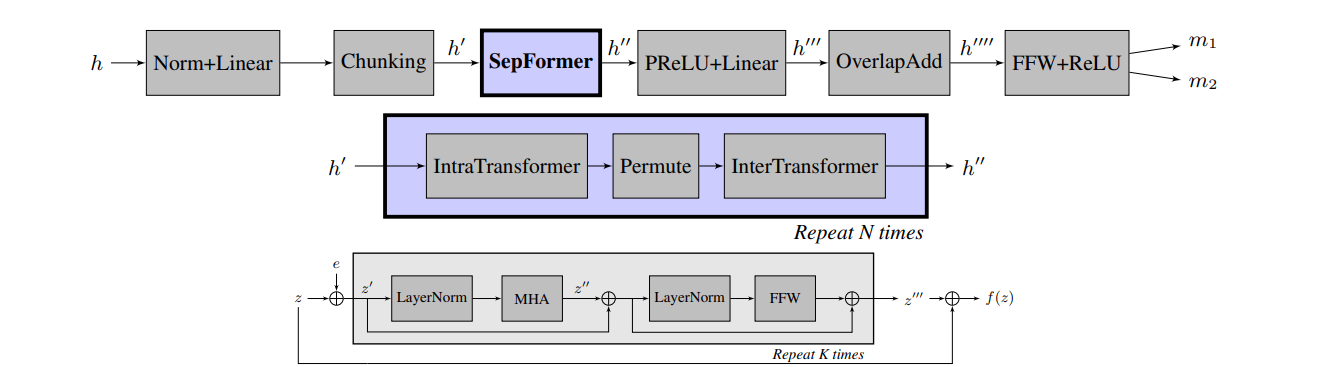
Source: https://arxiv.org/pdf/2010.13154

**Personal Interest**
SepFormer demonstrates that transformers can surpass RNNs in speech separation when combined with dual-path processing. Its hybrid local/global attention design bridges the gap between computational efficiency and separation quality. In order to run the transformer efficiently, we train on two heads only. It ends up acheiving decent sdri scores for a lot of tasks and is known as a state-of-the-art model. It however has a few key disadvantages, namely memory usage (Quadratic attention complexity) and higher compute costs. 

Here we train a kind of toned down "kiddie" version of sepformer to test and play with it. 

**References**
- https://arxiv.org/pdf/2010.13154
- https://github.com/speechbrain/speechbrain/blob/develop/recipes/WSJ0Mix/separation/hparams/sepformer.yaml


In [4]:
%%file sepformer-hparams.yaml
# ################################
# Model: Sepformer for Music vocal separation
# https://arxiv.org/abs/2010.13154
# Dataset : MusDB
# ################################
# Basic parameters
# Seed needs to be set at top of yaml, before objects with parameters are made


seed: 1234
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Data params

data_folder: !PLACEHOLDER
result_file_path: !PLACEHOLDER


experiment_name: sepformer
output_folder: !ref /notebooks/results/<experiment_name>/<seed>
train_log: !ref <output_folder>/train_log.txt
save_folder: !ref <output_folder>/save
train_data: !ref <output_folder>/train.json
valid_data: !ref <output_folder>/valid.json
test_data: !ref <output_folder>/test.json
skip_prep: False
db_path: '/notebooks/data'


# Experiment params
precision: fp16 # bf16, fp16 or fp32


noprogressbar: False
save_audio: True # Save estimated sources on disk
sample_rate: 8000
n_audio_to_save: 5
chunk_size: 20

####################### Training Parameters ####################################
N_epochs: 75
batch_size: 1
lr: 0.00015
clip_grad_norm: 5
loss_upper_lim: 999999  # this is the upper limit for an acceptable loss
num_sources: 2



# loss thresholding -- this thresholds the training loss
threshold_byloss: True
threshold: -30

# Encoder parameters
N_encoder_out: 256
out_channels: 256
kernel_size: 16
kernel_stride: 8

# Dataloader options
# Set num_workers: 0 on MacOS due to behavior of the multiprocessing library
dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: 3
    


####################### WaveDrop Params ########################################

use_wavedrop: True
# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 3  # Max number of audio chunks to drop
drop_chunk_length_low: 800  # Min length of audio chunks to drop
drop_chunk_length_high: 1600  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>
    
    

########################### Network Definition ####################
Encoder: !new:speechbrain.lobes.models.dual_path.Encoder
    kernel_size: !ref <kernel_size>
    out_channels: !ref <N_encoder_out>


SBtfintra: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 2
    d_model: !ref <out_channels>
    nhead: 4
    d_ffn: 1024
    dropout: 0
    use_positional_encoding: True
    norm_before: True

SBtfinter: !new:speechbrain.lobes.models.dual_path.SBTransformerBlock
    num_layers: 2
    d_model: !ref <out_channels>
    nhead: 4
    d_ffn: 1024
    dropout: 0
    use_positional_encoding: True
    norm_before: True

MaskNet: !new:speechbrain.lobes.models.dual_path.Dual_Path_Model
    num_spks: !ref <num_sources>
    in_channels: !ref <N_encoder_out>
    out_channels: !ref <out_channels>
    num_layers: 2
    K: 250
    intra_model: !ref <SBtfintra>
    inter_model: !ref <SBtfinter>
    norm: ln
    linear_layer_after_inter_intra: False
    skip_around_intra: True

Decoder: !new:speechbrain.lobes.models.dual_path.Decoder
    in_channels: !ref <N_encoder_out>
    out_channels: 1
    kernel_size: !ref <kernel_size>
    stride: !ref <kernel_stride>
    bias: False

optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0

loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper

lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.5
    patience: 2
    dont_halve_until_epoch: 75

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <N_epochs>

modules:
    encoder: !ref <Encoder>
    decoder: !ref <Decoder>
    masknet: !ref <MaskNet>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder: !ref <Encoder>
        decoder: !ref <Decoder>
        masknet: !ref <MaskNet>
        counter: !ref <epoch_counter>
        lr_scheduler: !ref <lr_scheduler>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

Overwriting sepformer-hparams.yaml


In [17]:
%%file sepformer-train.py
#!/usr/bin/env/python3
"""
Recipe for vocal separation using convtasnet
"""

import csv
import os
import sys

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm
import pdb

import musdb
import torchaudio
import numpy as np
from torch.utils.data import Dataset
import speechbrain as sb
import psutil
from dataset import MusDBDataset


import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.core import AMPConfig
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger
import time
from torch.utils.data import DataLoader

import musdb


# Define training procedure
class Separation(sb.Brain):
    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""

        # Unpack lists and put tensors in the right device
        mix, mix_lens = mix       
        mix, mix_lens = mix.to(self.device), mix_lens.to(self.device)      

        # Convert targets to tensor
        targets = torch.cat(
            [targets[i][0].unsqueeze(-1) for i in range(self.hparams.num_sources)],
            dim=-1,
        ).to(self.device)
        
        if stage == sb.Stage.TRAIN:
            with torch.no_grad():
                if self.hparams.use_wavedrop:
                    mix = self.hparams.drop_chunk(mix, mix_lens)
                    mix = self.hparams.drop_freq(mix)
        
        # Separation
        mix_w = self.hparams.Encoder(mix)
        est_mask = self.hparams.MaskNet(mix_w)
        mix_w = torch.stack([mix_w] * self.hparams.num_sources)
        sep_h = mix_w * est_mask
        
        # Decoding
        est_source = torch.cat(
            [
                self.hparams.Decoder(sep_h[i]).unsqueeze(-1)
                for i in range(self.hparams.num_sources)
            ],
            dim=-1,
        )

        # pad estimates as per requirement 
        T_origin = mix.size(1)
        T_est = est_source.size(1)
        if T_origin > T_est:
            est_source = F.pad(est_source, (0, 0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, :T_origin, :]

        return est_source, targets

    def compute_objectives(self, predictions, targets):
        """Computes the sinr loss"""
        return self.hparams.loss(targets, predictions)

    def fit_batch(self, batch):
        """Trains one batch"""
        
        
        amp = AMPConfig.from_name(self.precision)
        should_step = (self.step % self.grad_accumulation_factor) == 0
        # Unpacking batch list
        mixture = batch.mix_sig
        targets = [batch.voc_sig, batch.inst_sig] #mix_sig, voc_sig, inst_sig
       
        
        predictions, targets = self.compute_forward(
            mixture, targets, sb.Stage.TRAIN
        )
        loss = self.compute_objectives(predictions, targets)

        if self.hparams.threshold_byloss:
            th = self.hparams.threshold
            loss = loss[loss > th]
            if loss.nelement() > 0:
                loss = loss.mean()
        else:
            loss = loss.mean()

        if (
            loss.nelement() > 0 and loss < self.hparams.loss_upper_lim
        ):  # the fix for computational problems
            loss.backward()
            if self.hparams.clip_grad_norm >= 0:
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(),
                    self.hparams.clip_grad_norm,
                )
            self.optimizer.step()
        else:
            self.nonfinite_count += 1
            logger.info(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    self.nonfinite_count
                )
            )
            loss.data = torch.tensor(0.0).to(self.device)
        self.optimizer.zero_grad()

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        snt_id = batch.track_id
        mixture = batch.mix_sig
        targets = [batch.voc_sig, batch.inst_sig]

        with torch.no_grad():
            predictions, targets = self.compute_forward(mixture, targets, stage)
            loss = self.compute_objectives(predictions, targets)

        # Manage audio file saving
        if stage == sb.Stage.TEST and self.hparams.save_audio:
            if hasattr(self.hparams, "n_audio_to_save"):
                if self.hparams.n_audio_to_save > 0:
                    self.save_audio(snt_id[0], mixture, targets, predictions)
                    self.hparams.n_audio_to_save += -1
            else:
                self.save_audio(snt_id[0], mixture, targets, predictions)

        return loss.mean().detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]}, min_keys=["si-snr"]
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )

    def save_results(self, test_loader):
        """This script computes the SDR and SI-SNR metrics and saves
        them into a csv file"""

        # This package is required for SDR computation
        from mir_eval.separation import bss_eval_sources

        # Create folders where to store audio
        save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

        # Variable init
        all_sdrs = []
        all_sdrs_i = []
        all_sisnrs = []
        all_sisnrs_i = []
        csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]


        def is_silent(source, threshold=1e-6):
            return np.max(np.abs(source[0])) < threshold or np.max(np.abs(source[1])) < threshold

        with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
            writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
            writer.writeheader()
            skip_cnt = 0

            # Loop over all test sentence
            with tqdm(test_loader, dynamic_ncols=True) as t:
                for i, batch in enumerate(t):
                    # Apply Separation
                    mixture, mix_len = batch.mix_sig
                    snt_id = batch.track_id
                    targets = [batch.voc_sig, batch.inst_sig]
                   

                    with torch.no_grad():
                        predictions, targets = self.compute_forward(
                            batch.mix_sig, targets, sb.Stage.TEST
                        )

                    # Compute SI-SNR
                    sisnr = self.compute_objectives(predictions, targets)

                    # Compute SI-SNR improvement
                    mixture_signal = torch.stack(
                        [mixture] * self.hparams.num_sources, dim=-1
                    )
                    mixture_signal = mixture_signal.to(targets.device)
                    sisnr_baseline = self.compute_objectives(
                        mixture_signal, targets
                    )
                    sisnr_i = sisnr - sisnr_baseline
                    
     
                    if not is_silent(targets[0].t().cpu().numpy()) and not is_silent(predictions[0].t().detach().cpu().numpy()) and not is_silent(mixture_signal[0].t().detach().cpu().numpy()):
                        
                    
                        sdr, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            predictions[0].t().detach().cpu().numpy(),
                            compute_permutation=False
                        )
    
                        sdr_baseline, _, _, _ = bss_eval_sources(
                            targets[0].t().cpu().numpy(),
                            mixture_signal[0].t().detach().cpu().numpy(),
                            compute_permutation=False
                        )
    
                        sdr_i = sdr.mean() - sdr_baseline.mean()
    
                        # Saving on a csv file
                        row = {
                            "snt_id": snt_id[0],
                            "sdr": sdr.mean(),
                            "sdr_i": sdr_i,
                            "si-snr": -sisnr.item(),
                            "si-snr_i": -sisnr_i.item(),
                        }
                        writer.writerow(row)
    
                        # Metric Accumulation
                        all_sdrs.append(sdr.mean())
                        all_sdrs_i.append(sdr_i.mean())
                        all_sisnrs.append(-sisnr.item())
                        all_sisnrs_i.append(-sisnr_i.item())
                    else:
                        skip_cnt += 1
                        print(f"Warning: skipping silent target, this has happened {skip_cnt} times")
            row = {
                "snt_id": "avg",
                "sdr": np.array(all_sdrs).mean(),
                "sdr_i": np.array(all_sdrs_i).mean(),
                "si-snr": np.array(all_sisnrs).mean(),
                "si-snr_i": np.array(all_sisnrs_i).mean(),
            }
            writer.writerow(row)

        logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
        logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
        logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
        logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))
        if(self.hparams.result_file_path != ""):
            with open(self.hparams.result_file_path, "a", newline="", encoding="utf-8") as metrics_csv:
                writer = csv.DictWriter(metrics_csv, fieldnames=["model_name", "n_epochs", "learning_rate", "chunk_size", "sample_rate", "sdr", "sdr_i", "si-snr", "si-snr_i"])
                row = {
                        "model_name": self.hparams.experiment_name,
                        "learning_rate": self.hparams.lr,
                        "n_epochs": self.hparams.N_epochs,
                        "chunk_size":self.hparams.chunk_size,
                        "sample_rate":self.hparams.sample_rate,
                        "sdr": np.array(all_sdrs).mean(),
                        "sdr_i": np.array(all_sdrs_i).mean(),
                        "si-snr": np.array(all_sisnrs).mean(),
                        "si-snr_i": np.array(all_sisnrs_i).mean(),
                    }
                writer.writerow(row)

    def save_audio(self, snt_id, mixture, targets, predictions):
        "saves the test audio (mixture, targets, and estimated sources) on disk"

        # Create output folder
        save_path = os.path.join(self.hparams.save_folder, "audio_results")
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        for ns in range(self.hparams.num_sources):
            # Estimated source
            signal = predictions[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

            # Original source
            signal = targets[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
            )

        # Mixture
        signal = mixture[0][0, :]
        signal = signal / signal.abs().max()
        save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
        torchaudio.save(
            save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
        )





if __name__ == "__main__":
    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Logger info
    logger = get_logger(__name__)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Update precision to bf16 if the device is CPU and precision is fp16
    if run_opts.get("device") == "cpu" and hparams.get("precision") == "fp16":
        hparams["precision"] = "bf16"

   

    # Brain class initialization
    separator = Separation(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )
 
    # Training
        
    # Usage with SpeechBrain
    train_data = MusDBDataset(hparams["db_path"], subset="train", split="train", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    valid_data = MusDBDataset(hparams["db_path"], subset="train", split="valid", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    test_data = MusDBDataset(hparams["db_path"], subset="test", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    

    # Create DataLoader
    train_loader = sb.dataio.dataloader.make_dataloader(
        train_data,
        batch_size=hparams["batch_size"],
        shuffle=True,
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )

    valid_loader = sb.dataio.dataloader.make_dataloader(
        valid_data,
        batch_size=hparams["batch_size"],
        shuffle=True,
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )

    test_loader = sb.dataio.dataloader.make_dataloader(
        test_data,
        batch_size=hparams["batch_size"],
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )
    
    separator.fit(
        separator.hparams.epoch_counter,
        train_loader,
        valid_loader,
        train_loader_kwargs=hparams["dataloader_opts"],
        valid_loader_kwargs=hparams["dataloader_opts"],
    )

    # # Eval
    separator.evaluate(test_loader, min_key="si-snr")
    separator.save_results(test_loader)

Overwriting sepformer-train.py


In [3]:
!python3 sepformer-train.py sepformer-hparams.yaml --data_folder=db_path --result_file_path={result_file_path}

speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /notebooks/results/sepformer/1234
speechbrain.core - Info: precision arg from hparam file is used
speechbrain.core - Info: noprogressbar arg from hparam file is used
speechbrain.core - Gradscaler enabled: `True`
speechbrain.core - Using training precision: `--precision=fp16`
speechbrain.core - Using evaluation precision: `--eval_precision=fp32`
speechbrain.core - Separation Model Statistics:
* Total Number of Trainable Parameters: 6.7M
* Total Number of Parameters: 6.7M
* Trainable Parameters represent 100.0000% of the total size.
speechbrain.utils.checkpoints - Loading a checkpoint from /notebooks/results/sepformer/1234/save/CKPT+2025-04-24+08-55-02+00
speechbrain.utils.epoch_loop

### Point of Interest

```

loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper

```

All four of our models use this as the loss function. The **SI-SNR (Scale-Invariant Signal-to-Noise Ratio)** loss wrapped in a **Permutation Invariant Training (PIT)** framework (get_si_snr_with_pitwrapper). This loss function is ideal for source separation tasks because it addresses the permutation problem—where the order of output sources may not match the target sources—by computing all possible source-target assignments and selecting the one with the lowest loss. SI-SNR provides a perceptually meaningful measure of separation quality by evaluating signal reconstruction while being invariant to scale differences, making it robust for audio processing. This combination ensures stable training and high-quality separation results.

## Demucs v2 (Music Source Separation in the Waveform Domain)

**Key Idea**
Demucs v2 is a waveform-to-waveform U-Net model designed for music source separation, leveraging bidirectional LSTMs and time-domain convolutions to outperform spectrogram-based methods. It introduces pitch/tempo augmentation and overlap-add reconstruction to reduce artifacts at segment boundaries 102.

**Architecture**
- Encoder: Strided 1D convolutions to compress the waveform into latent features.
- Decoder: Transposed convolutions to reconstruct separated stems (drums, bass, vocals, etc.).
- Bidirectional LSTM: Bridges the encoder and decoder to capture long-term dependencies.

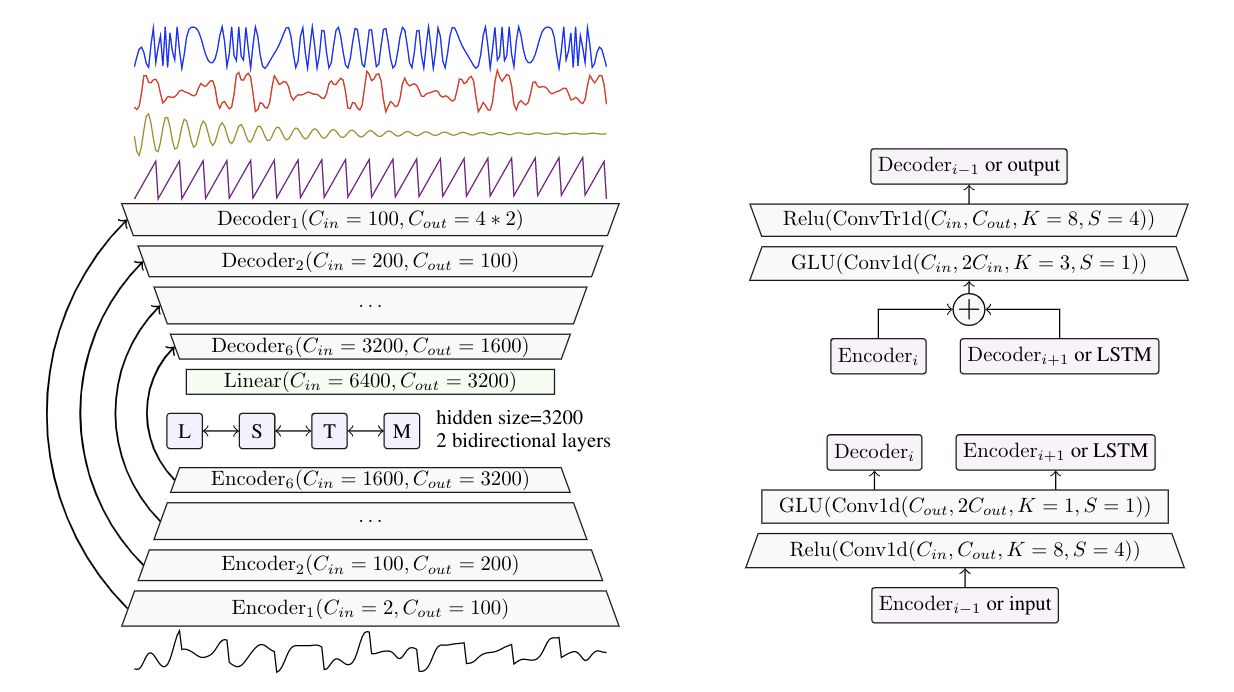


Source: https://github.com/facebookresearch/demucs/tree/v2

**Advantages**
- State-of-the-Art SDR: Achieves 6.3 dB on MUSDB (vs. 5.7 dB for Conv-Tasnet) without extra data 10.
- Natural Sounding Output: Human evaluations (MOS 3.2) favor Demucs over spectrogram methods 10.


**Personal Insights**
Demucs v2’s waveform-centric approach demonstrates that time-domain models can surpass spectrogram methods when combined with LSTMs and clever augmentation. It also feels empowering to develop a 250 million parameter model. 

However, Demucs is a large model which tends to give substantially better results as compared to most other models. This is hard to replicate in our use case because of the limitation of training instances as well as training data. The original demucs is trained on 44k sample rate over the course of 150 hours of music. 

**References**
- https://github.com/speechbrain/speechbrain/tree/develop/recipes/WSJ0Mix/separation
- https://github.com/facebookresearch/demucs/tree/v2
- https://github.com/f90/Wave-U-Net
- https://hal.science/hal-02379796/document

In [6]:
%%file demucsModels.py

import torch
from torch import nn
from speechbrain.nnet.CNN import Conv1d, ConvTranspose1d
# from speechbrain.nnet.activations import GLU
from speechbrain.lobes.models.beats import GLU_Linear
from torch.nn import GLU
from speechbrain.nnet.RNN import LSTM
from speechbrain.nnet.linear import Linear

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = Conv1d(
            out_channels=out_channels,
            in_channels=in_channels,
            kernel_size=8,
            stride=4,
            # default_padding=2,
            skip_transpose=True,
        )
        self.glu_conv = Conv1d(
            out_channels=2*out_channels,
            in_channels=out_channels,
            kernel_size=1,
            stride=1,
            skip_transpose=True,
        )
        self.relu = torch.nn.ReLU()
        self.glu = GLU(dim=1)

    def forward(self, x):
        
        x = self.relu(self.conv(x))
        
        x = self.glu(self.glu_conv(x))
        
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.glu_conv = Conv1d(
            out_channels=2*in_channels,
            in_channels=in_channels,
            kernel_size=1,
            stride=1,
            skip_transpose=True,
        )
        self.conv_tr = ConvTranspose1d(
            out_channels=out_channels,
            in_channels=in_channels,  # After GLU split
            kernel_size=8,
            stride=4,
            # padding=2,
            # output_padding=2,
            skip_transpose=True,
        )
        self.glu = GLU(dim=1)
        self.relu = torch.nn.ReLU()

    def forward(self, x, skip=None):

        if skip is not None:

            # T changed after conv1d in encoder, fix it here
            T_x = x.size(-1)
            T_skip = skip.size(-1)

            # # Case 1: Decoder output is longer
            # if T_skip > T_x:
            #     # Center-trim decoder output
            #     start = (T_skip - T_x) // 2
            #     skip = skip[..., start : start + T_x]

            # # Case 2: Skip is longer
            # elif T_skip < T_x:
            #     # Center-pad decoder output
            #     pad = T_x - T_skip
            #     skip = nn.functional.pad(skip, (pad // 2, pad - pad // 2))

            if T_skip > T_x:
                # Trim from the end of 'skip' to match 'x'
                skip = skip[..., :T_x]  # Keeps the first T_x samples

            # Case 2: Skip is shorter than target (x)
            elif T_skip < T_x:
                # Pad zeros at the end of 'skip' to match 'x'
                pad = T_x - T_skip
                skip = nn.functional.pad(skip, (0, pad))


            x = x + skip




        x = self.glu(self.glu_conv(x))

        x = self.relu(self.conv_tr(x))

        return x




class SourceSeparator(nn.Module):
    def __init__(self, in_channels, out_channels=2, num_sources=4):
        """
        Args:
            C_in: Input channels from last decoder (typically 8)
            C_out: Output channels per source (2 for stereo)
            num_sources: Number of sources to separate (e.g. 4 for vocals, drums, bass, other)
        """
        super().__init__()
        # Final linear layer (no activation)
        self.output_proj = Linear(
            input_size=in_channels,
            n_neurons=num_sources * out_channels,  # 4 sources * 2 channels = 8
            bias=True
        )
        self.num_sources = num_sources
        self.out_channels = out_channels

    def forward(self, x):
        """
        Input: [batch, C_in, time]
        Output: [batch, num_sources, out_channels, time]
        """
        # Permute to [batch, time, features]
        
        x = x.permute(0, 2, 1)

        # Project to source waveforms
        x = self.output_proj(x)  # [batch, time, num_sources*out_channels]
        

        # Reshape to separated sources
        
        x = x.permute(0, 2, 1)
        
        # Return as [batch, sources, time]
        return x

Overwriting demucsModels.py


In [3]:
%%file demucs-hparams.yaml

# ################################
# Model: Demucs for source separation
# https://hal.science/hal-02379796/document
# Dataset : Musdb
# ################################


seed: 1234
__set_seed: !apply:speechbrain.utils.seed_everything [!ref <seed>]

# Data params (unchanged from DPRNN)
data_folder: !PLACEHOLDER
result_file_path: !PLACEHOLDER

experiment_name: demucs
output_folder: !ref /notebooks/results/<experiment_name>/<seed>
train_log: !ref <output_folder>/train_log.txt
save_folder: !ref <output_folder>/save
train_data: !ref <output_folder>/train.json
valid_data: !ref <output_folder>/valid.json
test_data: !ref <output_folder>/test.json
skip_prep: False
db_path: !ref /notebooks/data


# Experiment params
precision: fp32
num_sources: 2


noprogressbar: False
save_audio: True
sample_rate: 16000
n_audio_to_save: 5
chunk_size: 20

####################### Training Parameters ####################################

N_epochs: 100
batch_size: 1
lr: 0.0003
clip_grad_norm: 5
loss_upper_lim: 999999
limit_training_signal_len: False
training_signal_len: 32000000

threshold_byloss: True
threshold: -30



####################### WaveDrop Params ########################################

use_wavedrop: True
# Frequency drop: randomly drops a number of frequency bands to zero.
drop_freq_low: 0  # Min frequency band dropout probability
drop_freq_high: 1  # Max frequency band dropout probability
drop_freq_count_low: 1  # Min number of frequency bands to drop
drop_freq_count_high: 3  # Max number of frequency bands to drop
drop_freq_width: 0.05  # Width of frequency bands to drop

drop_freq: !new:speechbrain.augment.time_domain.DropFreq
    drop_freq_low: !ref <drop_freq_low>
    drop_freq_high: !ref <drop_freq_high>
    drop_freq_count_low: !ref <drop_freq_count_low>
    drop_freq_count_high: !ref <drop_freq_count_high>
    drop_freq_width: !ref <drop_freq_width>

# Time drop: randomly drops a number of temporal chunks.
drop_chunk_count_low: 1  # Min number of audio chunks to drop
drop_chunk_count_high: 3  # Max number of audio chunks to drop
drop_chunk_length_low: 800  # Min length of audio chunks to drop
drop_chunk_length_high: 1600  # Max length of audio chunks to drop

drop_chunk: !new:speechbrain.augment.time_domain.DropChunk
    drop_length_low: !ref <drop_chunk_length_low>
    drop_length_high: !ref <drop_chunk_length_high>
    drop_count_low: !ref <drop_chunk_count_low>
    drop_count_high: !ref <drop_chunk_count_high>

################ Demucs Specific Parameters #############################


kernel_size: 16
# kernel_stride: 8

# Dataloader options (unchanged)
dataloader_opts:
    batch_size: !ref <batch_size>
    num_workers: 3

######################## Network Definition ####################################


Encoder1: !new:demucsModels.EncoderBlock
    in_channels: 1
    # kernel_size: !ref <kernel_size>
    out_channels: 64


Encoder2: !new:demucsModels.EncoderBlock
    in_channels: 64
    out_channels: 128


Encoder3: !new:demucsModels.EncoderBlock
    in_channels: 128
    out_channels: 256


Encoder4: !new:demucsModels.EncoderBlock
    in_channels: 256
    out_channels: 512


Encoder5: !new:demucsModels.EncoderBlock
    in_channels: 512
    out_channels: 1024


Encoder6: !new:demucsModels.EncoderBlock
    in_channels: 1024
    out_channels: 2048




Decoder6: !new:demucsModels.DecoderBlock
    in_channels: 2048
    out_channels: 1024


Decoder5: !new:demucsModels.DecoderBlock
    in_channels: 1024
    out_channels: 512


Decoder4: !new:demucsModels.DecoderBlock
    in_channels: 512
    out_channels: 256


Decoder3: !new:demucsModels.DecoderBlock
    in_channels: 256
    out_channels: 128


Decoder2: !new:demucsModels.DecoderBlock
    in_channels: 128
    out_channels: 64


Decoder1: !new:demucsModels.DecoderBlock
    in_channels: 64
    out_channels: 4


Linear: !new:speechbrain.nnet.linear.Linear
    input_size: 4096
    bias: False
    n_neurons: 2048

BiLSTM: !new:speechbrain.nnet.RNN.LSTM
    hidden_size: 2048
    input_size: 2048
    num_layers: 2
    bidirectional: True
    # batch_first: True

LinearSeparator: !new:demucsModels.SourceSeparator
    in_channels: 4
    out_channels: 1
    num_sources: !ref <num_sources>


######################## Remaining Config ######################################
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    weight_decay: 0

# loss: !name:speechbrain.nnet.losses.mse_loss
loss: !name:speechbrain.nnet.losses.get_si_snr_with_pitwrapper
# loss: !name:speechbrain.nnet.losses.l1_loss


lr_scheduler: !new:speechbrain.nnet.schedulers.ReduceLROnPlateau
    factor: 0.5
    patience: 2
    dont_halve_until_epoch: 50

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <N_epochs>

modules:
    encoder1: !ref <Encoder1>
    encoder2: !ref <Encoder2>
    encoder3: !ref <Encoder3>
    encoder4: !ref <Encoder4>
    encoder5: !ref <Encoder5>
    encoder6: !ref <Encoder6>
    lstm: !ref <BiLSTM>
    linear: !ref <Linear>
    decoder6: !ref <Decoder6>
    decoder5: !ref <Decoder5>
    decoder4: !ref <Decoder4>
    decoder3: !ref <Decoder3>
    decoder2: !ref <Decoder2>
    decoder1: !ref <Decoder1>
    linearSeparator: !ref <LinearSeparator>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        encoder1: !ref <Encoder1>
        encoder2: !ref <Encoder2>
        encoder3: !ref <Encoder3>
        encoder4: !ref <Encoder4>
        encoder5: !ref <Encoder5>
        encoder6: !ref <Encoder6>
        lstm: !ref <BiLSTM>
        linear: !ref <Linear>
        decoder6: !ref <Decoder6>
        decoder5: !ref <Decoder5>
        decoder4: !ref <Decoder4>
        decoder3: !ref <Decoder3>
        decoder2: !ref <Decoder2>
        decoder1: !ref <Decoder1>
        linearSeparator: !ref <LinearSeparator>
        counter: !ref <epoch_counter>


train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

Overwriting demucs-hparams.yaml


In [4]:
%%file demucs-train.py
#!/usr/bin/env/python3
"""Recipe for training a neural speech separation system on the wsjmix
dataset. The system employs an encoder, a decoder, and a masking network.

To run this recipe, do the following:
> python train.py hparams/sepformer.yaml
> python train.py hparams/dualpath_rnn.yaml
> python train.py hparams/convtasnet.yaml

The experiment file is flexible enough to support different neural
networks. By properly changing the parameter files, you can try
different architectures. The script supports both wsj2mix and
wsj3mix.


Authors
 * Cem Subakan 2020
 * Mirco Ravanelli 2020
 * Samuele Cornell 2020
 * Mirko Bronzi 2020
 * Jianyuan Zhong 2020
"""
## CHECKPOINT
import csv
import os
import sys

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from hyperpyyaml import load_hyperpyyaml
from tqdm import tqdm



import speechbrain as sb
import speechbrain.nnet.schedulers as schedulers
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.logger import get_logger
from speechbrain.nnet.CNN import Conv1d, ConvTranspose1d
# from speechbrain.nnet.activations import GLU
from speechbrain.lobes.models.beats import GLU_Linear
from torch.nn import GLU
from speechbrain.nnet.RNN import LSTM
from speechbrain.nnet.linear import Linear
from demucsModels import EncoderBlock, DecoderBlock
from speechbrain.nnet.losses import get_si_snr_with_pitwrapper
from dataset import MusDBDataset

from torch.utils.data import Dataset
import musdb
np.float_ = np.float64





# Define training procedure
class DemucsSeparation(sb.Brain):
    # def on_fit_start(self):


    def compute_forward(self, mix, targets, stage, noise=None):
        """Forward computations from the mixture to the separated signals."""

        # Unpack lists and put tensors in the right device
        mix, mix_lens = mix
        mix, mix_lens = mix.to(self.device), mix_lens.to(self.device)

        # Convert targets to tensor
        
        targets = torch.cat(
            [targets[i][0].unsqueeze(-1) for i in range(self.hparams.num_sources)],
            dim=-1,
        ).to(self.device)
        
        if stage == sb.Stage.TRAIN:
            with torch.no_grad():
    
                if self.hparams.use_wavedrop:
                    mix = self.hparams.drop_chunk(mix, mix_lens)
                    mix = self.hparams.drop_freq(mix)
        
        mix=mix.unsqueeze(1)
        targets=targets.permute(0,2,1)
           

        mix_enc_1 = self.modules.encoder1(mix)
        mix_enc_2 = self.modules.encoder2(mix_enc_1)
        mix_enc_3 = self.modules.encoder3(mix_enc_2)
        mix_enc_4 = self.modules.encoder4(mix_enc_3)
        mix_enc_5 = self.modules.encoder5(mix_enc_4)
        mix_enc_6 = self.modules.encoder6(mix_enc_5)

        lstm_in = mix_enc_6.permute(0,2,1)
        lstm_out, _ = self.modules.lstm(lstm_in) # outputs both -- outputs as well as hidden states -- we dont need hidden states
        lin_out = self.modules.linear(lstm_out)
        lin_out = lin_out.permute(0,2,1)

        mix_dec_6 = self.modules.decoder6(lin_out, skip=mix_enc_6)
        mix_dec_5 = self.modules.decoder5(mix_dec_6, skip=mix_enc_5)
        mix_dec_4 = self.modules.decoder4(mix_dec_5, skip=mix_enc_4)
        mix_dec_3 = self.modules.decoder3(mix_dec_4, skip=mix_enc_3)
        mix_dec_2 = self.modules.decoder2(mix_dec_3, skip=mix_enc_2)
        mix_dec_1 = self.modules.decoder1(mix_dec_2, skip=mix_enc_1)

        mix_out = self.modules.linearSeparator(mix_dec_1)
        est_source = mix_out



        # T changed after conv1d in encoder, fix it here
        T_origin = targets.size(2)
        T_est = est_source.size(2)

        if T_origin > T_est:
            est_source = F.pad(est_source, (0, 0, T_origin - T_est))
        else:
            est_source = est_source[:, : , :T_origin]

        return est_source, targets

    def compute_objectives(self, predictions, targets):
        """Computes the sinr loss"""
        
        targets = targets.permute(0,2,1)
        predictions = predictions.permute(0,2,1)
        return self.hparams.loss(targets, predictions) # for pitwrapper
## CHECKPOINT
    def fit_batch(self, batch):
        """Trains one batch"""

        # Unpacking batch list
        mixture = batch.mix_sig
        targets = [batch.voc_sig, batch.inst_sig]

        with self.training_ctx:
            predictions, targets = self.compute_forward(
                mixture, targets, sb.Stage.TRAIN
            )

            loss = self.compute_objectives(predictions, targets)

            # hard threshold the easy dataitems
            if self.hparams.threshold_byloss:
                th = self.hparams.threshold
                loss = loss[loss > th]
                if loss.nelement() > 0:
                    loss = loss.mean()
            else:
                loss = loss.mean()

        if loss.nelement() > 0 and loss < self.hparams.loss_upper_lim:
            self.scaler.scale(loss).backward()
            if self.hparams.clip_grad_norm >= 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    self.modules.parameters(),
                    self.hparams.clip_grad_norm,
                )
            self.scaler.step(self.optimizer)
            self.scaler.update()
        else:
            self.nonfinite_count += 1
            logger.info(
                "infinite loss or empty loss! it happened {} times so far - skipping this batch".format(
                    self.nonfinite_count
                )
            )
            loss.data = torch.tensor(0.0).to(self.device)
        self.optimizer.zero_grad()

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        snt_id = batch.track_id
        mixture = batch.mix_sig
        targets = [batch.voc_sig, batch.inst_sig]


        with torch.no_grad():
            predictions, targets = self.compute_forward(mixture, targets, stage)
            loss = self.compute_objectives(predictions, targets)

        # Manage audio file saving
        if stage == sb.Stage.TEST and self.hparams.save_audio:
            if hasattr(self.hparams, "n_audio_to_save"):
                if self.hparams.n_audio_to_save > 0:
                    self.save_audio(snt_id, mixture, targets, predictions)
                    self.hparams.n_audio_to_save += -1
            else:
                self.save_audio(snt_id, mixture, targets, predictions)

        return loss.mean().detach()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"si-snr": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:
            # Learning rate annealing
            if isinstance(
                self.hparams.lr_scheduler, schedulers.ReduceLROnPlateau
            ):
                current_lr, next_lr = self.hparams.lr_scheduler(
                    [self.optimizer], epoch, stage_loss
                )
                schedulers.update_learning_rate(self.optimizer, next_lr)
            else:
                # if we do not use the reducelronplateau, we do not change the lr
                current_lr = self.hparams.optimizer.optim.param_groups[0]["lr"]

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": current_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"si-snr": stage_stats["si-snr"]}, min_keys=["si-snr"]
            )
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )


    def save_results(self, test_loader):
        """This script computes the SDR and SI-SNR metrics and saves
        them into a csv file"""

        # This package is required for SDR computation
        from mir_eval.separation import bss_eval_sources

        # Create folders where to store audio
        save_file = os.path.join(self.hparams.output_folder, "test_results.csv")

        # Variable init
        all_sdrs = []
        all_sdrs_i = []
        all_sisnrs = []
        all_sisnrs_i = []
        csv_columns = ["snt_id", "sdr", "sdr_i", "si-snr", "si-snr_i"]

        # test_loader = sb.dataio.dataloader.make_dataloader(
        #     test_data, **self.hparams.dataloader_opts
        # )

        with open(save_file, "w", newline="", encoding="utf-8") as results_csv:
            writer = csv.DictWriter(results_csv, fieldnames=csv_columns)
            writer.writeheader()

            # Loop over all test sentence
            with tqdm(test_loader, dynamic_ncols=True) as t:
                for i, batch in enumerate(t):
                    # Apply Separation
                    mixture, mix_len = batch.mix_sig
                    snt_id = batch.track_id
                    targets = [batch.voc_sig, batch.inst_sig]


                    with torch.no_grad():
                        predictions, targets = self.compute_forward(
                            batch.mix_sig, targets, sb.Stage.TEST
                        )

                    # Compute SI-SNR
                    predictions = predictions.permute(0,2,1)
                    targets = targets.permute(0,2,1)
                    
                    # sisnr = self.compute_objectives(predictions, targets)
                    sisnr = get_si_snr_with_pitwrapper(predictions,targets)

                    # Compute SI-SNR improvement
                    mixture_signal = torch.stack(
                        [mixture] * self.hparams.num_sources, dim=-1
                    )
                   
                    mixture_signal = mixture_signal.to(targets.device)
                    # sisnr_baseline = self.compute_objectives(
                    #     mixture_signal, targets
                    # )
                    sisnr_baseline = get_si_snr_with_pitwrapper(mixture_signal, targets)
                    sisnr_i = sisnr - sisnr_baseline

                    # Compute SDR
                    sdr, _, _, _ = bss_eval_sources(
                        targets[0].mean(dim=1).t().cpu().numpy(),
                        predictions[0].mean(dim=1).t().detach().cpu().numpy(),
                    )

                    sdr_baseline, _, _, _ = bss_eval_sources(
                        targets[0].mean(dim=1).t().cpu().numpy(),
                        mixture_signal[0].mean(dim=1).t().detach().cpu().numpy(),
                    )

                    sdr_i = sdr.mean() - sdr_baseline.mean()

                    # Saving on a csv file
                    row = {
                        "snt_id": snt_id[0],
                        "sdr": sdr.mean(),
                        "sdr_i": sdr_i,
                        "si-snr": -sisnr.item(),
                        "si-snr_i": -sisnr_i.item(),
                    }
                    writer.writerow(row)

                    # Metric Accumulation
                    all_sdrs.append(sdr.mean())
                    all_sdrs_i.append(sdr_i.mean())
                    all_sisnrs.append(-sisnr.item())
                    all_sisnrs_i.append(-sisnr_i.item())

                row = {
                    "snt_id": "avg",
                    "sdr": np.array(all_sdrs).mean(),
                    "sdr_i": np.array(all_sdrs_i).mean(),
                    "si-snr": np.array(all_sisnrs).mean(),
                    "si-snr_i": np.array(all_sisnrs_i).mean(),
                }
                writer.writerow(row)

        logger.info("Mean SISNR is {}".format(np.array(all_sisnrs).mean()))
        logger.info("Mean SISNRi is {}".format(np.array(all_sisnrs_i).mean()))
        logger.info("Mean SDR is {}".format(np.array(all_sdrs).mean()))
        logger.info("Mean SDRi is {}".format(np.array(all_sdrs_i).mean()))
        if(self.hparams.result_file_path != ""):
            with open(self.hparams.result_file_path, "a", newline="", encoding="utf-8") as metrics_csv:
                writer = csv.DictWriter(metrics_csv, fieldnames=["model_name", "n_epochs", "learning_rate", "chunk_size", "sample_rate", "sdr", "sdr_i", "si-snr", "si-snr_i"])
                row = {
                        "model_name": self.hparams.experiment_name,
                        "learning_rate": self.hparams.lr,
                        "n_epochs": self.hparams.N_epochs,
                        "chunk_size":self.hparams.chunk_size,
                        "sample_rate":self.hparams.sample_rate,
                        "sdr": np.array(all_sdrs).mean(),
                        "sdr_i": np.array(all_sdrs_i).mean(),
                        "si-snr": np.array(all_sisnrs).mean(),
                        "si-snr_i": np.array(all_sisnrs_i).mean(),
                    }
                writer.writerow(row)

    def save_audio(self, snt_id, mixture, targets, predictions):
        "saves the test audio (mixture, targets, and estimated sources) on disk"

        # Create output folder

        save_path = os.path.join(self.hparams.save_folder, "audio_results")
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        targets = targets.permute(0,2,1)
        predictions = predictions.permute(0,2,1)
        
        for ns in range(self.hparams.num_sources):
            # Estimated source\
            
            
            signal = predictions[0, :, ns]
            
            signal = signal / signal.abs().max()
            
            save_file = os.path.join(
                save_path, "item{}_source{}hat.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate, channels_first=True
            )

            # Original source
            signal = targets[0, :, ns]
            signal = signal / signal.abs().max()
            save_file = os.path.join(
                save_path, "item{}_source{}.wav".format(snt_id, ns + 1)
            )
            torchaudio.save(
                save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate, channels_first=True
            )

        # Mixture
        signal = mixture[0][0, :]
        signal = signal / signal.abs().max()
        
        save_file = os.path.join(save_path, "item{}_mix.wav".format(snt_id))
        torchaudio.save(
            save_file, signal.unsqueeze(0).cpu(), self.hparams.sample_rate
        )



if __name__ == "__main__":
    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file, encoding="utf-8") as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Logger info
    logger = get_logger(__name__)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Update precision to bf16 if the device is CPU and precision is fp16
    if run_opts.get("device") == "cpu" and hparams.get("precision") == "fp16":
        hparams["precision"] = "bf16"



        # Usage with SpeechBrain
    train_data = MusDBDataset(hparams["db_path"], subset="train", split="train", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    valid_data = MusDBDataset(hparams["db_path"], subset="train", split="valid", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])
    test_data = MusDBDataset(hparams["db_path"], subset="test", target_sr=hparams["sample_rate"], chunk_size=hparams["chunk_size"])


    # Create DataLoader
    train_loader = sb.dataio.dataloader.make_dataloader(
        train_data,
        batch_size=hparams["batch_size"],
        shuffle=True,
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )

    valid_loader = sb.dataio.dataloader.make_dataloader(
        valid_data,
        batch_size=hparams["batch_size"],
        shuffle=True,
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )

    test_loader = sb.dataio.dataloader.make_dataloader(
        test_data,
        batch_size=hparams["batch_size"],
        collate_fn=sb.dataio.batch.PaddedBatch  # Handles variable lengths
    )


    # Brain class initialization
    separator = DemucsSeparation(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )


    # Training
    separator.fit(
        separator.hparams.epoch_counter,
        train_loader,
        valid_loader,
        train_loader_kwargs=hparams["dataloader_opts"],
        valid_loader_kwargs=hparams["dataloader_opts"],
    )

    # Eval
    separator.evaluate(test_loader, min_key="si-snr")
    separator.save_results(test_loader)
    ## CHECKPOINT

Overwriting demucs-train.py


In [3]:
!python demucs-train.py demucs-hparams.yaml --data_folder=db_path --result_file_path={result_file_path}

speechbrain.utils.quirks - Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
speechbrain.utils.quirks - Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /notebooks/results/demucs/1234
speechbrain.core - Info: precision arg from hparam file is used
speechbrain.core - Info: noprogressbar arg from hparam file is used
speechbrain.core - Gradscaler enabled: `False`
speechbrain.core - Using training precision: `--precision=fp32`
speechbrain.core - Using evaluation precision: `--eval_precision=fp32`
speechbrain.core - DemucsSeparation Model Statistics:
* Total Number of Trainable Parameters: 243.3M
* Total Number of Parameters: 243.3M
* Trainable Parameters represent 100.0000% of the total size.
speechbrain.utils.checkpoints - Loading a checkpoint from /notebooks/results/demucs/1234/save/CKPT+2025-04-22+07-44-25+00
speechbrain.utils.epoch

## Generating Results

Ohh the sweet and savory.... Finally we get to discussing our results for the entire set of models. First things first, the below snippet of code generates a sweet little table for us to see how our models perform and improve across training and training instances. 

Before that.... context sil vous plait ;)

What exactly do these four terms mean...

### SiSNR  (Scale-Invariant Signal-to-Noise Ratio)

SI-SNR measures the quality of source separation by comparing the reconstructed signal to the original target. Higher values (closer to +inf dB) mean better separation, while low/negative values indicate poor reconstruction (noise dominates). Ideal values depend on the task, but >10 dB is typically good, while <0 dB suggests failure.


### SiSNR_i  (Scale-Invariant Signal-to-Noise Ratio - Improvement)
SI-SNRi compares the model’s output to the original mixture. Positive values mean the model improved separation, while negative values mean it performed worse than the input mix. A value of +3 dB or higher is desirable, while negative SI-SNRi indicates the model is degrading the signal.

### SDR (Source-to-Distortion Ratio)
SDR evaluates overall signal fidelity, considering distortions and artifacts. Higher SDR (>0 dB) means cleaner separation, while negative values indicate severe distortion. Values below -10 dB suggest unusable output.

### SDR_i (SDR Improvement)
SDRi measures how much better (or worse) the model is compared to the original mixture. Positive SDRi means improvement, while negative values imply the output is worse than the mix. A well-trained model should have SDRi > 0 dB, with higher values (e.g., +5 dB+) indicating strong performance.


Ok so with that in mind...(drumroll)... scroll down to see the verdict

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

if result_file_path is not None:
    df = pd.read_csv(result_file_path)
else:
    # Sample data 
    data = {
        'model_name': ['demucs'],
        'batch_size': [1],
        'n_epochs': [30],
        'n_samples': [8000],
        'chunk_size': [30],
        'snt_id': [-11.316875255705217],
        'sdr': [-45.328893867866654],
        'sdr_i': [-19.785856680436567],
        'si-snr': [-14.166560108011419],
        'si-snr_i': [-14.166560108011419]
    }
    df = pd.DataFrame(data)


def create_table(df):
    
    formatted_df = df.copy()
    formatted_df['learning_rate'] = (formatted_df['learning_rate'] * 1000)
    float_cols = df.select_dtypes(include=['float64']).columns
   
    formatted_df[float_cols] = formatted_df[float_cols].round(2)
    table = tabulate(formatted_df, headers='keys', tablefmt='grid', showindex=True)
    return table

def create_plots(df):
    plt.figure(figsize=(40, 10))
    
    metrics = ['sdr', 'sdr_i', 'si-snr', 'si-snr_i']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.bar(df['model_name'], df[metric], color=colors[i])
        plt.title(f'{metric.upper()} Comparison', fontweight='bold')
        plt.ylabel('dB')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        for j, val in enumerate(df[metric]):
            plt.text(j, val/2, f'{val:.2f}', ha='center', color='white', fontweight='bold')
    
    plt.tight_layout()
    return plt


In [13]:

# Display results
print("=== Formatted Table ===")
print("learning rate : x 10^(-4)")
print(create_table(df))


=== Formatted Table ===
learning rate : x 10^(-4)
+----+--------------+------------+-----------------+--------------+---------------+--------+---------+----------+------------+
|    | model_name   |   n_epochs |   learning_rate |   chunk_size |   sample_rate |    sdr |   sdr_i |   si-snr |   si-snr_i |
+====+==============+============+=================+==============+===============+========+=========+==========+============+
|  0 | convtasnet   |         10 |            0.15 |           20 |          8000 |  -7.15 |   -7.7  |    -0.06 |       1.05 |
+----+--------------+------------+-----------------+--------------+---------------+--------+---------+----------+------------+
|  1 | dprnn        |         10 |            0.15 |           20 |          8000 |   4.24 |    3.69 |     1.05 |       2.16 |
+----+--------------+------------+-----------------+--------------+---------------+--------+---------+----------+------------+
|  2 | sepformer    |         10 |            0.15 |         

<Figure size 1500x1000 with 0 Axes>

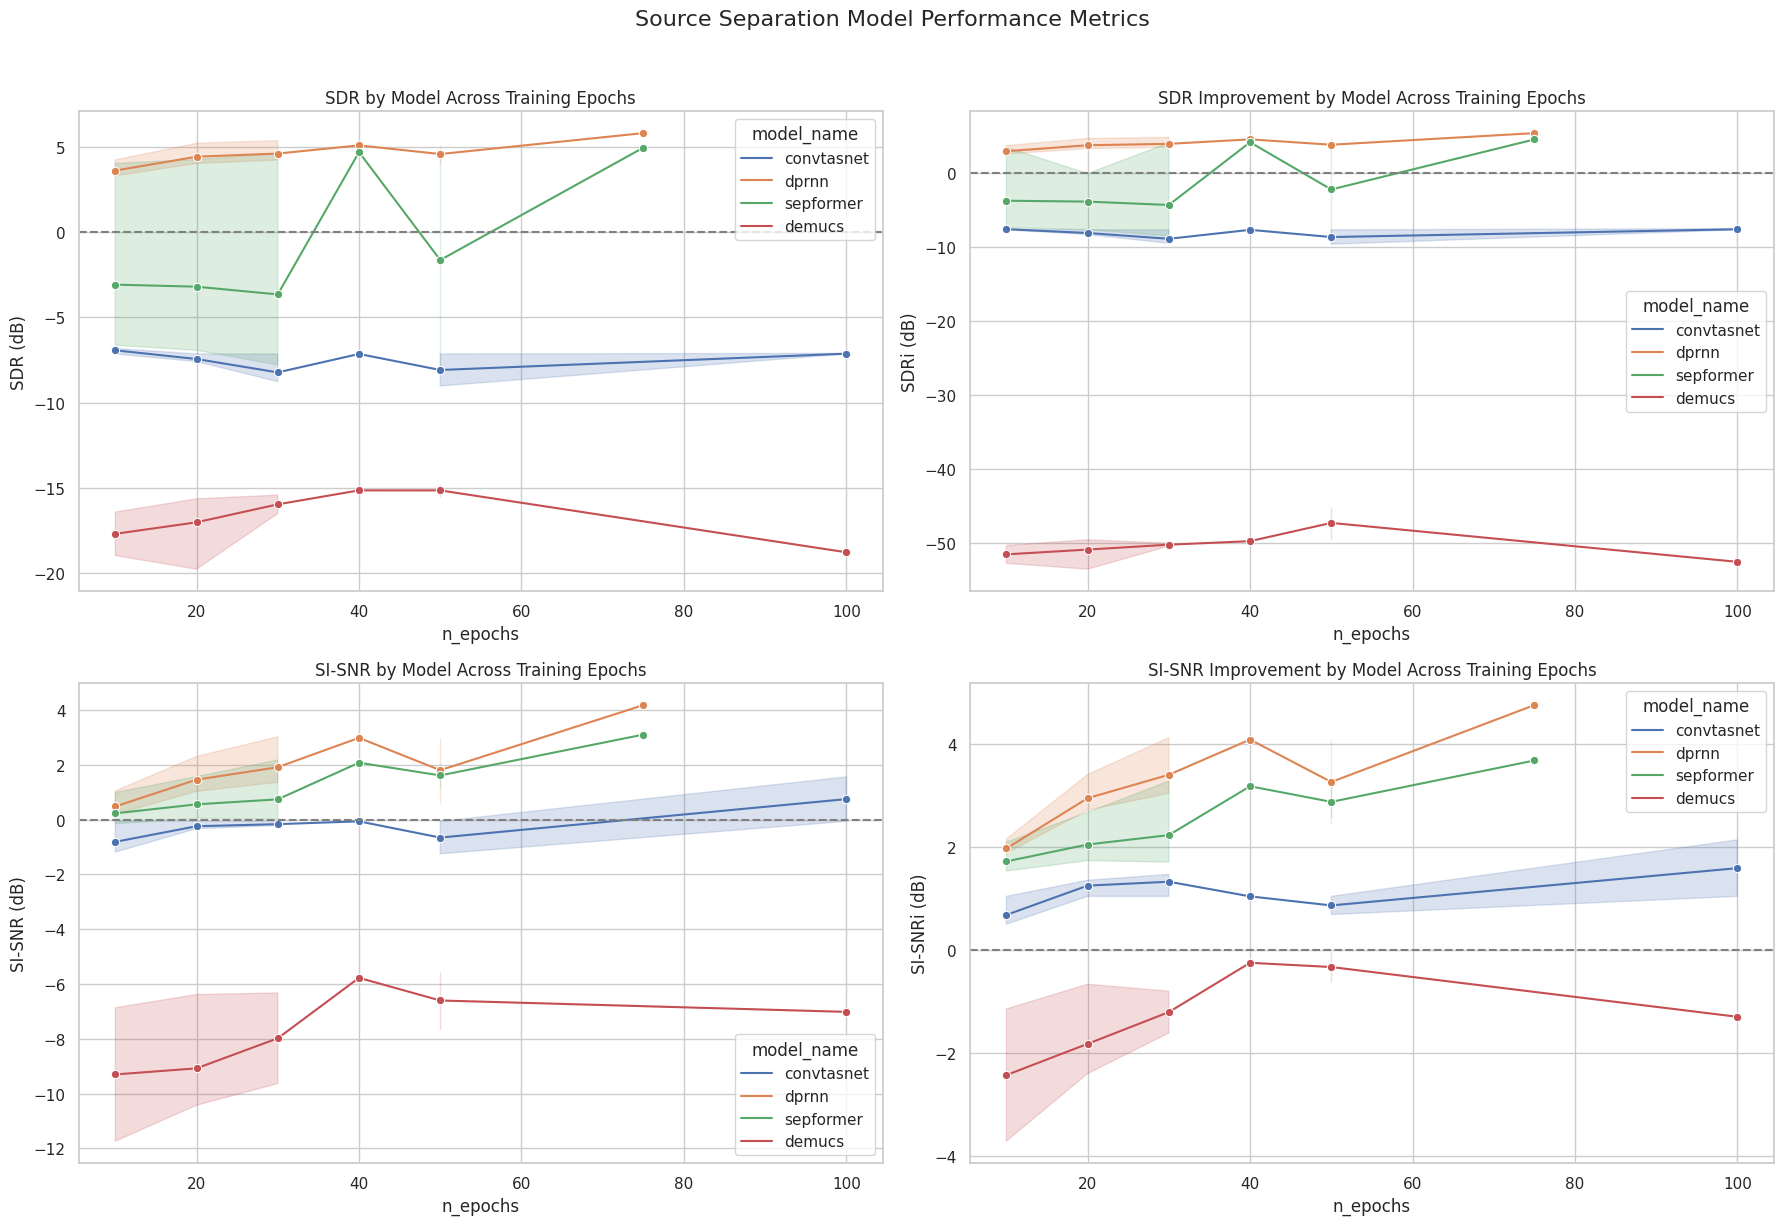


Best Performing Models:
- Highest SDR: dprnn (epoch 75) - 5.81 dB
- Highest SDRi: dprnn (epoch 75) - 5.38 dB
- Highest SI-SNR: dprnn (epoch 75) - 4.18 dB
- Highest SI-SNRi: dprnn (epoch 75) - 4.76 dB


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Clean up column names
formatted_df = df.copy()
formatted_df.columns = formatted_df.columns.str.replace('-', '_')

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.suptitle('Source Separation Model Performance Metrics', y=1.02, fontsize=16)

# Plot 1: SDR by Model and Epochs
sns.lineplot(data=formatted_df, x='n_epochs', y='sdr', hue='model_name', marker='o', ax=axes[0,0])
axes[0,0].set_title('SDR by Model Across Training Epochs')
axes[0,0].set_ylabel('SDR (dB)')
axes[0,0].axhline(0, color='gray', linestyle='--')

# Plot 2: SDRi by Model and Epochs
sns.lineplot(data=formatted_df, x='n_epochs', y='sdr_i', hue='model_name', marker='o', ax=axes[0,1])
axes[0,1].set_title('SDR Improvement by Model Across Training Epochs')
axes[0,1].set_ylabel('SDRi (dB)')
axes[0,1].axhline(0, color='gray', linestyle='--')

# Plot 3: SI-SNR by Model and Epochs
sns.lineplot(data=formatted_df, x='n_epochs', y='si_snr', hue='model_name', marker='o', ax=axes[1,0])
axes[1,0].set_title('SI-SNR by Model Across Training Epochs')
axes[1,0].set_ylabel('SI-SNR (dB)')
axes[1,0].axhline(0, color='gray', linestyle='--')

# Plot 4: SI-SNRi by Model and Epochs
sns.lineplot(data=formatted_df, x='n_epochs', y='si_snr_i', hue='model_name', marker='o', ax=axes[1,1])
axes[1,1].set_title('SI-SNR Improvement by Model Across Training Epochs')
axes[1,1].set_ylabel('SI-SNRi (dB)')
axes[1,1].axhline(0, color='gray', linestyle='--')

# Adjust layout
plt.tight_layout()

# Save figures
plt.savefig('separation_metrics.png', bbox_inches='tight', dpi=300)
plt.show()

# Additional analysis: Best performing models
best_sdr = formatted_df.loc[formatted_df['sdr'].idxmax()]
best_sdri = formatted_df.loc[formatted_df['sdr_i'].idxmax()]
best_sisnr = formatted_df.loc[formatted_df['si_snr'].idxmax()]
best_sisnri = formatted_df.loc[formatted_df['si_snr_i'].idxmax()]

print("\nBest Performing Models:")
print(f"- Highest SDR: {best_sdr['model_name']} (epoch {best_sdr['n_epochs']}) - {best_sdr['sdr']:.2f} dB")
print(f"- Highest SDRi: {best_sdri['model_name']} (epoch {best_sdri['n_epochs']}) - {best_sdri['sdr_i']:.2f} dB")
print(f"- Highest SI-SNR: {best_sisnr['model_name']} (epoch {best_sisnr['n_epochs']}) - {best_sisnr['si_snr']:.2f} dB")
print(f"- Highest SI-SNRi: {best_sisnri['model_name']} (epoch {best_sisnri['n_epochs']}) - {best_sisnri['si_snr_i']:.2f} dB")

## Results 

As plainly visible, We see that DPRNN is the clear winner in terms of objective metrics touching an aggregate SDRI of 6.0 dB. This is followed by Sepformer coming in second at close to an SDRi of 5.2. These figures tell us that for the given sample rates namely 8000 and 16000 Hz with 20 and 10 second chunks of audio respectively, these two models are able to absorb enough features to moderately successfully discern between the test audio chunks. 

As for ConvTasnet and Demucs, both being convolutional models, both underperform as compared to their online posted SDR scores. This comes as a surprise but one can gauge why this could be the case. Beyond the reasoning of a lack of data size and a lack of sample space, one can dive deeper into the nitty grities of why this could potentially be the case. Lets do that progressively

Additionally, one must also remember:

    "Life is all about the process... not the final event" 
        -- Mohnish Mirchandani

Across the table we see the following trends
- As we increase the epoch sizes (train the models more) we see a convergence of the validation loss up to a certain extent and thus an increase in sdri scores. This however plateaus at a certain region (Around epoch 20 and 30 ish for all).
- We implement wave drop to generalize better which takes us a little further
- We then try and improve upon by introducing random shifting (around the 50 epoch mark) to make the model learn on more data. This can be seen by the valley formed in the graphs. More data essentially is always better
 


### Model Specific Learnings
- One aspect of demucs implemented in our version is that we use the si-snr loss while the original sources uses an l1 loss. This is because earlier trials with our version of demucs give horrible outputs due to the model learning noise instead of the sources
- Demucs is a behemoth and it takes monumental changes to make any kind of improvement in the same.
- Convtasnet does not perform upto industry standards. This can be attributed to the smaller mask size and 256 channels while the industry conventionaly uses 1024. 
- The Success of DPRNN and Sepformer both indicate that although music seperation does not rely on long term dependencies... having a recurrent or attention block i.e focusing on relative surroundings improves quality



### Inference
One can see that DPRNN plays out to be the best model and the reason for that is potentially the fact that it isnt too complicated to not learn anything from the smaller dataset but not even so simple that it is unable to do much with what it has learned. The same goes for sepformer but sepformer is computationally expensive unless you tone it down to a level where you can play with it. 


## Fruits of Thy Labour


In [26]:
from IPython.display import Audio

Audio('/notebooks/result_audio/result_1_mix_dprnn.wav')



In [29]:

Audio('/notebooks/result_audio/result_1_voc_dprnn.wav')


In [28]:
# DPRNN - Inst Results
Audio('/notebooks/result_audio/result_1_inst_dprnn.wav')


In [31]:
# Sepformer - Vocals Result 
Audio('/notebooks/result_audio/result_2_voc_sepf.wav')

In [32]:
# Sepformer - Inst Result
Audio('/notebooks/result_audio/result_2_inst_sepf.wav')

# That's All Folks

And with that... we successfully drew up and tested four models, and ... thoroughly enjoyed conversational AI.


### Other References
- https://pytorch.org/audio/main/models.html
- https://pytorch.org/audio/main/generated/torchaudio.models.HDemucs.html#torchaudio.models.HDemucs
- https://arxiv.org/abs/2205.13657
- https://github.com/f90/Wave-U-Net-Pytorch
- https://github.com/JusperLee/Deep-Encoder-Decoder-Conv-TasNet
- https://github.com/speechbrain/speechbrain/tree/develop/recipes/BinauralWSJ0Mix/separation
- https://medium.com/data-science/ai-music-source-separation-how-it-works-and-why-it-is-so-hard-187852e54752
- https://www.kaggle.com/datasets/dakshsethi/musdb18
- https://paperswithcode.com/dataset/medleydb
- https://github.com/faroit/stempeg
- https://ffmpeg.org/
- https://github.com/deezer/spleeter

